<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/model_acc_from_drift_0409.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Default Prediction - Neural Network

References

*   Learning under Concept Drift: A Review (https://www.usenix.org/system/files/sec21summer_yang.pdf)
*   G. Ditzler, M. Roveri, C. Alippi, and R. Polikar, “Learning in
nonstationary environments: a survey,” IEEE Comput. Intell. Mag.,
vol. 10, no. 4, pp. 12–25, 2015. (https://ieeexplore.ieee.org/document/7296710)
*   Concept Drift Detection in Data Stream Mining: The Review of
Contemporary Literature (https://core.ac.uk/download/pdf/231150802.pdf)
*   Early Drift Detection Method (https://www.cs.upc.edu/~abifet/EDDM.pdf)
*   https://en.wikipedia.org/wiki/Concept_drift
*  A Survey on Concept Drift Adaptation (https://www.win.tue.nl/~mpechen/publications/pubs/Gama_ACMCS_AdaptationCD_accepted.pdf)









Concept drift는 p(y|X) 에서, y와 X의 상관관계의 변화가 발생하는 경우를 의미 한다.

즉, 현실의 y와 X의 상관관계는 변화 하는데, 모델의 p(y^|X)는 변화하지 않으면서, 예측의 성능이 저하된다.

Concept drift의 발생 과정을 다음과 같이 구분 할 수 있다. (Bayes' theorem의 3개 term에 준하여 설명)

1. y 자체(p(y))가 바뀌는 경우, 예를 들어 정책 (rule)에 의해 바뀌는 경우. 논문 (B. Ramakrishna & Dr. S Krishna Mohan Rao, 2017, "Concept Drift Detection in Data Stream Mining: The Review of Contemporary Literature")에서는, "1) Drift by **prior probability** (a change in learnt decision boundary):" 으로 표현하고 있다. 

2. X가 변화 하면서 (Data drift), 결정경계 (decision boundry)를 넘게 될 때



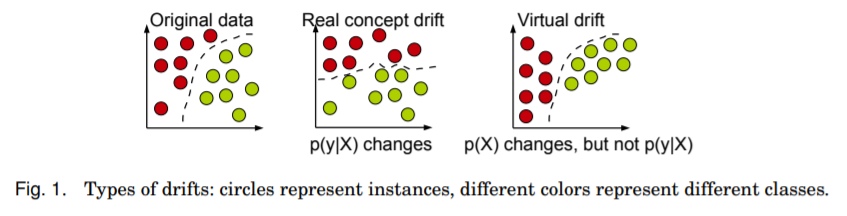

그림인용 :JOAO GAMA, 2017, "A Survey on Concept Drift Adaptation"


위의 그림에서, Virtual drift = Data drift before concept drift, 상황에서 그 정도가 심해지고, 결정경계가 변화 (중간. Real concept drift) 할 수 있다.

논문 (B. Ramakrishna & Dr. S Krishna Mohan Rao, 2017, "Concept Drift Detection in Data Stream Mining: The Review of Contemporary Literature")에서는, "2) Drift by **condition** (decision boundary change influenced by condition)" 으로 표현하고 있다.

3. X의 dimension이 변화, 특히 줄어드는 경우가 아닌 증가 하는 경우, 더 이상 X는 y를 설명 할 수 없다. 이러한 경우는 새로운 X의 dimension을 찾아야 한다.
 -> 어떻게 detect 할 것 인가????

논문 (B. Ramakrishna & Dr. S Krishna Mohan Rao, 2017, "Concept Drift Detection in Data Stream Mining: The Review of Contemporary Literature")에서는, "3) Drift by **posterior probability** (a change influenced by the conflict of old and new decision boundary):" 으로 표현하고 있다.


1과 2의 경우, 1,2의 내용이 포함된 새로운 정상성 데이터셋(stationary dataset)에 의해 다시 학습하면 예측성능을 회복 할 수 있다. 그러나 3의 경우, 우리가 갖고 있는 데이터는 이미 (non-stationary)한 상태로서 labeling을 하고 다시 학습하여도 예측성능을 회복 할 수 없다.

https://www.kaggle.com/errearanhas/default-prediction-neural-network-99-acc

##Introduction

Using historical data on loans from Lendig Club - including information on whether or not the borrower defaulted (charge-off) - the main objective of this notebook will be to predict if a potential borrower is likely to pay back the loan.

After explore and pre-process data, we are going to train a Neural Network binary classification model in order to achive this objective. Finally, we evaluate model performance and simulate its operation with a new customer prediction.

Notebook sections:

1. Import data
2. Exploratory Data Analysis
3. Pre-processing
4. Define and train Model
5. Evaluate Model

p.s. work inspired by the excellent Tf2 and Keras DL Bootcamp

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!pip3 install shap
!pip3 install alibi-detect
!pip3 install lime

     |████████████████████████████████| 564 kB 4.3 MB/s 
     |████████████████████████████████| 246 kB 4.3 MB/s 
     |████████████████████████████████| 4.0 MB 33.3 MB/s 
     |████████████████████████████████| 4.8 MB 84.0 MB/s 
     |████████████████████████████████| 462 kB 60.3 MB/s 
     |████████████████████████████████| 596 kB 64.0 MB/s 
     |████████████████████████████████| 77 kB 8.9 MB/s 
     |████████████████████████████████| 6.5 MB 64.8 MB/s 
     |████████████████████████████████| 895 kB 82.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.16.0
    Uninstalling tensorflow-probability-0.16.0:
      Successfully uninstalled tensorflow-probability-0.16.0
     |████████████████████████████████| 275 kB 4.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-

In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [4]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2260701, 151)


##Exploratory Data Analysis (and some initial pre-processing)

Since we are going to predict loan_status, let's take a brief closer look on it:

In [5]:
df_accepted.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

for the sake of simplicity, let's consider only Fully Paid and Charged Off values:

In [6]:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]

print(df_accepted.shape)

(1345310, 151)


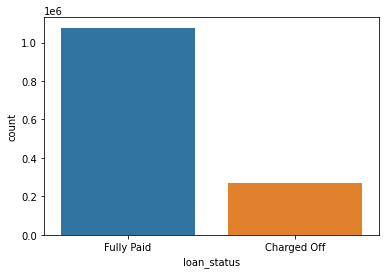

In [7]:
sns.countplot(x="loan_status", data=df_accepted)

checking now null values per columns:

In [8]:
df_accepted.isnull().sum().sort_values(ascending=False)

next_pymnt_d                                  1345310
member_id                                     1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_length                               1339556
                                               ...   
pub_rec                                             0
open_acc                                            0
fico_range_high                                     0
fico_range_low                                      0
id                                                  0
Length: 151, dtype: int64

wow, there is a bunch of columns almost full of missing values. Let's check the first 50 columns sorted by missing values:

In [9]:
df_accepted.isnull().sum().sort_values(ascending=False).head(50)

next_pymnt_d                                  1345310
member_id                                     1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_length                               1339556
hardship_type                                 1339556
hardship_reason                               1339556
hardship_status                               1339556
deferral_term                                 1339556
hardship_amount                               1339556
hardship_end_date                             1339556
payment_plan_start_date                       1339556
hardship_dpd                                  1339556
hardship_loan_status                          1339556
hardship_payoff_balance_amount                1339556
hardship_last_payment_amount                  1339556
sec_app_mths_since_last_major_derog           1338665
sec_app_revol_util                            1327008
revol_bal_joint             

let's drop these columns, as it will not contribute to our goal.

In [10]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 101)

let's check again:

In [11]:
df_accepted.isnull().sum().sort_values(ascending=False).head(50)

total_bal_il                  807712
open_act_il                   807712
open_rv_12m                   807712
open_rv_24m                   807712
inq_fi                        807712
open_il_12m                   807712
open_il_24m                   807712
mths_since_last_delinq        678743
mths_since_recent_inq         174071
num_tl_120dpd_2m              117401
mo_sin_old_il_acct            105575
emp_title                      85785
emp_length                     78511
pct_tl_nvr_dlq                 67681
avg_cur_bal                    67549
mo_sin_rcnt_rev_tl_op          67528
num_rev_accts                  67528
mo_sin_old_rev_tl_op           67528
num_actv_rev_tl                67527
num_actv_bc_tl                 67527
num_il_tl                      67527
num_accts_ever_120_pd          67527
num_bc_tl                      67527
total_il_high_credit_limit     67527
num_rev_tl_bal_gt_0            67527
num_op_rev_tl                  67527
tot_cur_bal                    67527
t

maybe we can go further, and eliminate columns up to title:

In [12]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 56)

In [13]:
print(df_accepted['issue_d'])

0          Dec-2015
1          Dec-2015
2          Dec-2015
4          Dec-2015
5          Dec-2015
             ...   
2260688    Oct-2016
2260690    Oct-2016
2260691    Oct-2016
2260692    Oct-2016
2260697    Oct-2016
Name: issue_d, Length: 1345310, dtype: object


for the remaining columns with missing values, let's see the missing percentage:

In [14]:
nulls = df_accepted.isnull().sum().sort_values(ascending=False)
nulls_percentage = (nulls/df_accepted.shape[0]*100)
nulls_percentage.head(15)

last_pymnt_d                  0.171931
revol_util                    0.063703
pub_rec_bankruptcies          0.051810
dti                           0.027800
chargeoff_within_12_mths      0.004163
collections_12_mths_ex_med    0.004163
last_credit_pull_d            0.004088
tax_liens                     0.002899
inq_last_6mths                0.000074
zip_code                      0.000074
delinq_amnt                   0.000000
disbursement_method           0.000000
out_prncp_inv                 0.000000
total_pymnt                   0.000000
total_pymnt_inv               0.000000
dtype: float64

Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():

In [15]:
df_accepted = df_accepted.dropna()
df_accepted.shape

(1341026, 56)

In [16]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341026 entries, 0 to 2260697
Data columns (total 56 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1341026 non-null  object 
 1   loan_amnt                   1341026 non-null  float64
 2   funded_amnt                 1341026 non-null  float64
 3   funded_amnt_inv             1341026 non-null  float64
 4   term                        1341026 non-null  object 
 5   int_rate                    1341026 non-null  float64
 6   installment                 1341026 non-null  float64
 7   grade                       1341026 non-null  object 
 8   sub_grade                   1341026 non-null  object 
 9   home_ownership              1341026 non-null  object 
 10  annual_inc                  1341026 non-null  float64
 11  verification_status         1341026 non-null  object 
 12  issue_d                     1341026 non-null  object 
 1

let's now take a look at loan_amnt histogram, to have an idea of the amount distribution:

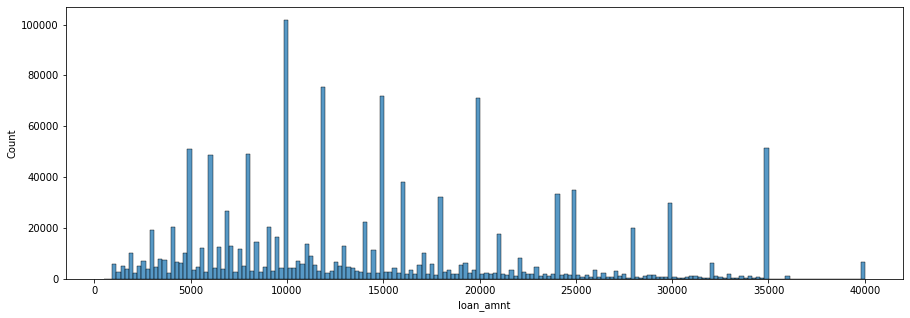

In [17]:
plt.figure(figsize=(15,5))
sns.histplot(df_accepted.loan_amnt, kde=False)

let's now see the correlation between continuous variables:

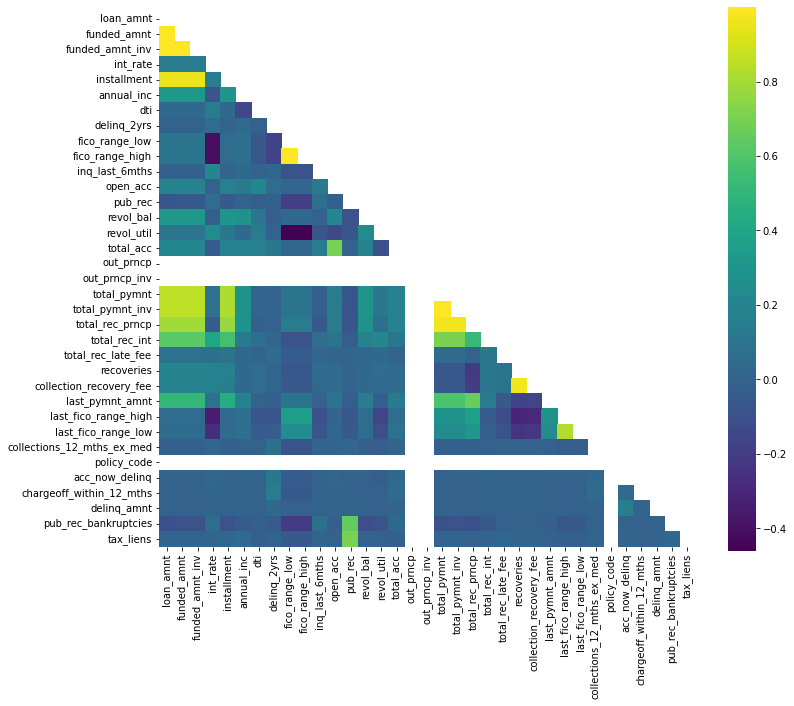

In [18]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(df_accepted.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_accepted.corr(), cmap='viridis', mask=mask, annot=False, square=True)

there are 3 columns with a visible different behaviour: out_prncp, out_prncp_inv and policy_code.

In [19]:
print(df_accepted.out_prncp.value_counts())
print(df_accepted.out_prncp_inv.value_counts())
print(df_accepted.policy_code.value_counts())

0.0    1341026
Name: out_prncp, dtype: int64
0.0    1341026
Name: out_prncp_inv, dtype: int64
1.0    1341026
Name: policy_code, dtype: int64


These are constant columns. We can drop it either.

In [20]:
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 53)

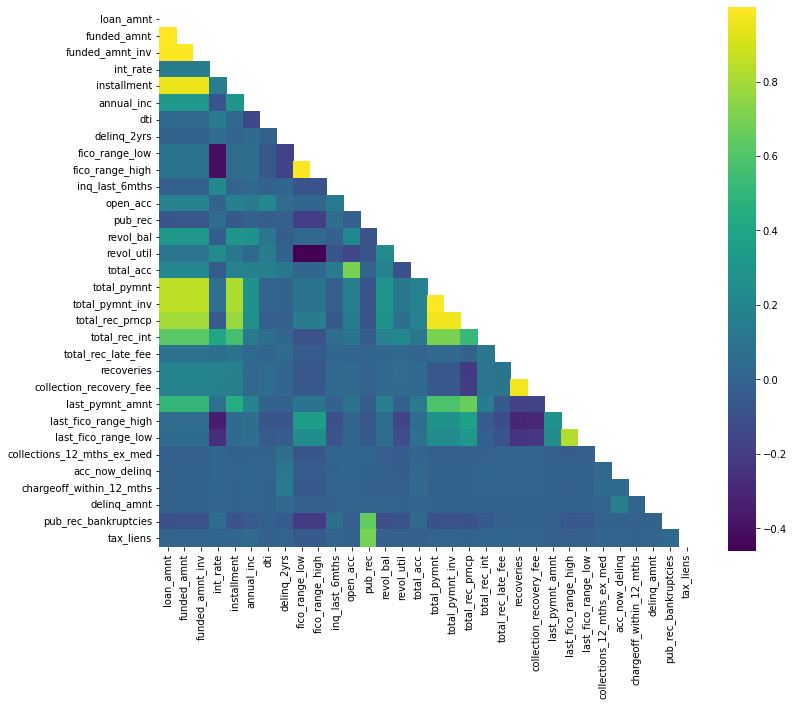

In [21]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(df_accepted.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_accepted.corr(), cmap='viridis', mask=mask, annot=False, square=True)

There are many yellowish squares. This indicates almost perfect correlation between many variables. Let's dig deeper:

In [22]:
# unstacking correlation to check highest correlation pairs

c = df_accepted.corr().abs()
unstack_corr = c.unstack()
pairs = unstack_corr.sort_values(ascending=False)

corr_pairs = pd.DataFrame(pairs).drop_duplicates().reset_index()
corr_pairs.columns = ['feature1', 'feature2', 'corr']


# check feature pairs above 0.8 in correlation

cond1 = (corr_pairs.feature1 != corr_pairs.feature2)
cond2 = (corr_pairs['corr']>0.80)

corr_pairs[cond1 & cond2]

feature1                 feature2      corr
1        fico_range_low          fico_range_high  1.000000
2           funded_amnt                loan_amnt  0.999565
3       total_pymnt_inv              total_pymnt  0.999541
4       funded_amnt_inv              funded_amnt  0.999439
5       funded_amnt_inv                loan_amnt  0.998918
6            recoveries  collection_recovery_fee  0.972674
7           total_pymnt          total_rec_prncp  0.967104
8       total_rec_prncp          total_pymnt_inv  0.966725
9           funded_amnt              installment  0.954037
10          installment          funded_amnt_inv  0.953445
11            loan_amnt              installment  0.953387
12      total_pymnt_inv          funded_amnt_inv  0.857150
13          funded_amnt              total_pymnt  0.856901
14      total_pymnt_inv              funded_amnt  0.856675
15            loan_amnt              total_pymnt  0.856658
16          total_pymnt          funded_amnt_inv  0.856443
17      total_pymnt_inv                loan_amnt  0.856355
18  last_fico_range_low     last_fico_range_high  0.829740
19          installment              total_pymnt  0.818291
20          installment          total_pymnt_inv  0.818049

Let's perform scatterplot and visually check some relationships among these features:

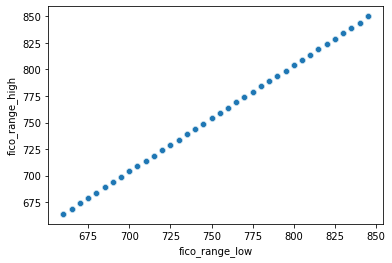

In [23]:
sns.scatterplot(x=df_accepted.fico_range_low, y=df_accepted.fico_range_high)

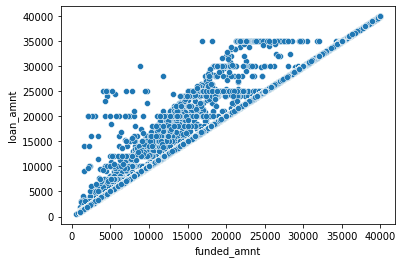

In [24]:
sns.scatterplot(x=df_accepted.funded_amnt, y=df_accepted.loan_amnt)

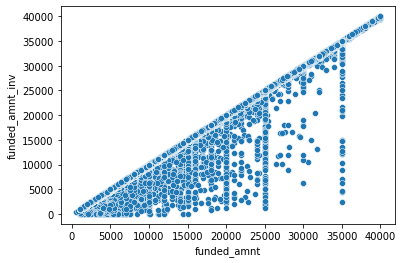

In [25]:
sns.scatterplot(x=df_accepted.funded_amnt, y=df_accepted.funded_amnt_inv)

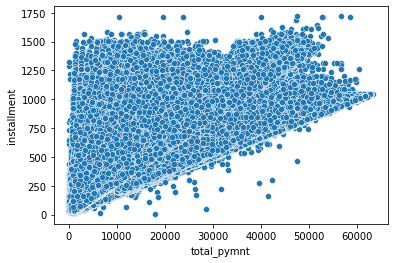

In [26]:
sns.scatterplot(x=df_accepted.total_pymnt, y=df_accepted.installment)

It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:

In [27]:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 44)

as our target column is categorical (loan_status), let's create a new feature - loan_paid - that is 1 for 'Fully Paid' and 0 for 'Charged Off'

In [28]:
values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))

In [29]:
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)

df_accepted = df_accepted.drop(columns=['loan_status'])

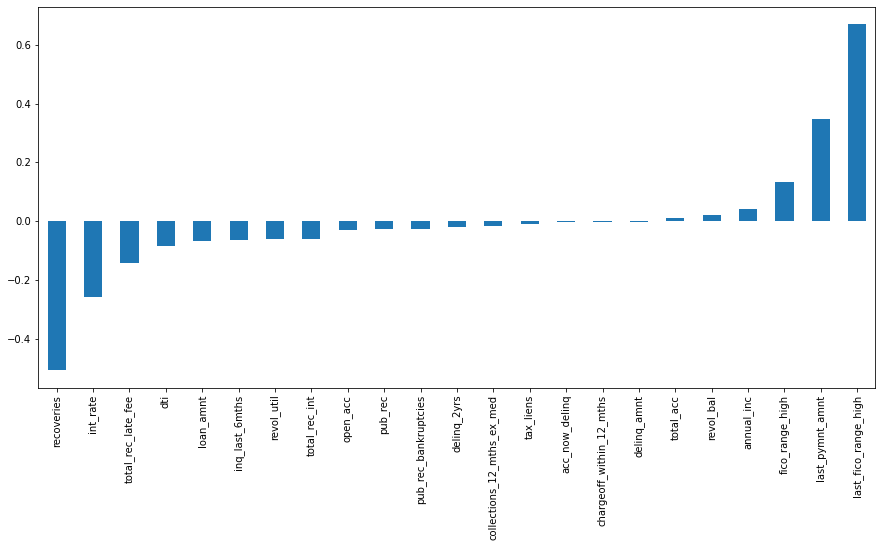

In [30]:
# checking correlation of features to the new loan_paid column


plt.figure(figsize=(15,7))
new_corr = df_accepted.corr().iloc[:-1,-1].sort_values()
new_corr.plot.bar(rot=90)

##Pre-processing

we still have many string categorical columns. Let's work on it:

In [31]:
df_accepted

id  loan_amnt        term  int_rate grade sub_grade  \
0        68407277     3600.0   36 months     13.99     C        C4   
1        68355089    24700.0   36 months     11.99     C        C1   
2        68341763    20000.0   60 months     10.78     B        B4   
4        68476807    10400.0   60 months     22.45     F        F1   
5        68426831    11950.0   36 months     13.44     C        C3   
...           ...        ...         ...       ...   ...       ...   
2260688  89905081    18000.0   60 months      9.49     B        B2   
2260690  88948836    29400.0   60 months     13.99     C        C3   
2260691  89996426    32000.0   60 months     14.49     C        C4   
2260692  90006534    16000.0   60 months     12.79     C        C1   
2260697  88224441    24000.0   60 months     14.49     C        C4   

        home_ownership  annual_inc verification_status   issue_d  ...  \
0             MORTGAGE     55000.0        Not Verified  Dec-2015  ...   
1             MORTGAGE     65000.0        Not Verified  Dec-2015  ...   
2             MORTGAGE     63000.0        Not Verified  Dec-2015  ...   
4             MORTGAGE    104433.0     Source Verified  Dec-2015  ...   
5                 RENT     34000.0     Source Verified  Dec-2015  ...   
...                ...         ...                 ...       ...  ...   
2260688            OWN    130000.0        Not Verified  Oct-2016  ...   
2260690       MORTGAGE    180792.0        Not Verified  Oct-2016  ...   
2260691       MORTGAGE    157000.0     Source Verified  Oct-2016  ...   
2260692           RENT    150000.0        Not Verified  Oct-2016  ...   
2260697           RENT    110000.0        Not Verified  Oct-2016  ...   

        application_type acc_now_delinq chargeoff_within_12_mths delinq_amnt  \
0             Individual            0.0                      0.0         0.0   
1             Individual            0.0                      0.0         0.0   
2              Joint App            0.0                      0.0         0.0   
4             Individual            0.0                      0.0         0.0   
5             Individual            0.0                      0.0         0.0   
...                  ...            ...                      ...         ...   
2260688       Individual            0.0                      0.0         0.0   
2260690       Individual            0.0                      0.0         0.0   
2260691       Individual            0.0                      0.0         0.0   
2260692       Individual            0.0                      0.0         0.0   
2260697       Individual            0.0                      0.0         0.0   

        pub_rec_bankruptcies  tax_liens  hardship_flag disbursement_method  \
0                        0.0        0.0              N                Cash   
1                        0.0        0.0              N                Cash   
2                        0.0        0.0              N                Cash   
4                        0.0        0.0              N                Cash   
5                        0.0        0.0              N                Cash   
...                      ...        ...            ...                 ...   
2260688                  0.0        0.0              N                Cash   
2260690                  0.0        0.0              N                Cash   
2260691                  0.0        0.0              N                Cash   
2260692                  3.0        0.0              N                Cash   
2260697                  1.0        0.0              N                Cash   

         debt_settlement_flag  loan_paid  
0                           N          1  
1                           N          1  
2                           N          1  
4                           N          1  
5                           N          1  
...                       ...        ...  
2260688                     N          1  
2260690                     N          1  
2260691     

In [32]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)
df_accepted[cat_cols]

Index(['id', 'term', 'grade', 'sub_grade', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'hardship_flag', 'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


id        term grade sub_grade home_ownership  \
0        68407277   36 months     C        C4       MORTGAGE   
1        68355089   36 months     C        C1       MORTGAGE   
2        68341763   60 months     B        B4       MORTGAGE   
4        68476807   60 months     F        F1       MORTGAGE   
5        68426831   36 months     C        C3           RENT   
...           ...         ...   ...       ...            ...   
2260688  89905081   60 months     B        B2            OWN   
2260690  88948836   60 months     C        C3       MORTGAGE   
2260691  89996426   60 months     C        C4       MORTGAGE   
2260692  90006534   60 months     C        C1           RENT   
2260697  88224441   60 months     C        C4           RENT   

        verification_status   issue_d pymnt_plan  \
0              Not Verified  Dec-2015          n   
1              Not Verified  Dec-2015          n   
2              Not Verified  Dec-2015          n   
4           Source Verified  Dec-2015          n   
5           Source Verified  Dec-2015          n   
...                     ...       ...        ...   
2260688        Not Verified  Oct-2016          n   
2260690        Not Verified  Oct-2016          n   
2260691     Source Verified  Oct-2016          n   
2260692        Not Verified  Oct-2016          n   
2260697        Not Verified  Oct-2016          n   

                                                       url  \
0        https://lendingclub.com/browse/loanDetail.acti...   
1        https://lendingclub.com/browse/loanDetail.acti...   
2        https://lendingclub.com/browse/loanDetail.acti...   
4        https://lendingclub.com/browse/loanDetail.acti...   
5        https://lendingclub.com/browse/loanDetail.acti...   
...                                                    ...   
2260688  https://lendingclub.com/browse/loanDetail.acti...   
2260690  https://lendingclub.com/browse/loanDetail.acti...   
2260691  https://lendingclub.com/browse/loanDetail.acti...   
2260692  https://lendingclub.com/browse/loanDetail.acti...   
2260697  https://lendingclub.com/browse/loanDetail.acti...   

                    purpose zip_code addr_state earliest_cr_line  \
0        debt_consolidation    190xx         PA         Aug-2003   
1            small_business    577xx         SD         Dec-1999   
2          home_improvement    605xx         IL         Aug-2000   
4            major_purchase    174xx         PA         Jun-1998   
5        debt_consolidation    300xx         GA         Oct-1987   
...                     ...      ...        ...              ...   
2260688    home_improvement    775xx         TX         Jul-2004   
2260690  debt_consolidation    900xx         CA         Mar-2002   
2260691    home_improvement    863xx         AZ         Jun-2011   
2260692             medical    284xx         NC         Aug-1997   
2260697  debt_consolidation    334xx         FL         Jul-1999   

        initial_list_status last_pymnt_d last_credit_pull_d application_type  \
0                         w     Jan-2019           Mar-2019       Individual   
1                         w     Jun-2016           Mar-2019       Individual   
2                         w     Jun-2017           Mar-2019        Joint App   
4                         w     Jul-2016           Mar-2018       Individual   
5                         w     May-2017           May-2017       Individual   
...                     ...          ...                ...              ...   
2260688                   f     Aug-2018           Mar-2019       Individual   
2260690                   f     Jul-2018           Jul-2018       Individual   
2260691                   f     Mar-2017           Dec-2018       Individual   
2260692                   f     Mar-2018           Mar-2019       Individual   
2260697                   f     Oct-2017           Mar-2019       Individual   

        hardship_flag disbursement_method debt_settlement_flag  
0                   N            

In [33]:
# droping constant columns

print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())

cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64


(1341026, 41)

In [34]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


In [35]:
print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

 36 months    1017398
 60 months     323628
Name: term, dtype: int64


In [36]:
print(df_accepted.grade.value_counts())
print(df_accepted.sub_grade.value_counts())

B    391850
C    380490
A    234657
D    200019
E     93126
F     31854
G      9030
Name: grade, dtype: int64
C1    85247
B4    83003
B5    82327
B3    81658
C2    78960
C3    74781
C4    74173
B2    73870
B1    70992
C5    67329
A5    63892
A4    52135
D1    51092
D2    44637
A1    43634
D3    39134
A3    37900
A2    37096
D4    35412
D5    29744
E1    23657
E2    21244
E3    18279
E4    15621
E5    14325
F1     9914
F2     7149
F3     6055
F4     4826
F5     3910
G1     2967
G2     2109
G3     1600
G4     1259
G5     1095
Name: sub_grade, dtype: int64


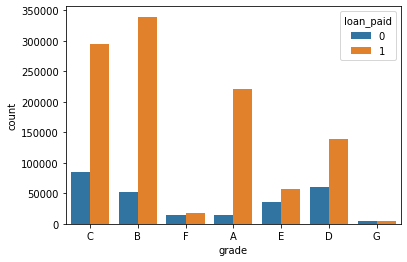

In [37]:
# checking count per grade and loan_paid

sns.countplot(x=df_accepted.grade, hue=df_accepted.loan_paid)

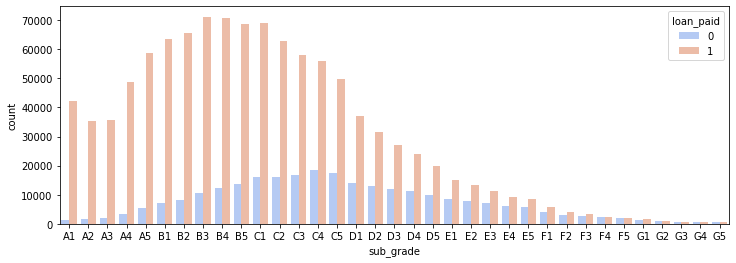

In [38]:
# checking count per subgrade and loan_paid

l = list(df_accepted.sub_grade.unique())
l.sort()

plt.figure(figsize=(12,4))
sns.countplot(x=df_accepted.sub_grade, order=l, hue=df_accepted.loan_paid, palette='coolwarm')

In [39]:
# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

In [40]:
df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

In [41]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


features verification_status, application_type, initial_list_status, purpose

In [42]:
print(df_accepted.verification_status.unique())
print(df_accepted.application_type.unique())
print(df_accepted.initial_list_status.unique())
print(df_accepted.purpose.unique())

['Not Verified' 'Source Verified' 'Verified']
['Individual' 'Joint App']
['w' 'f']
['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational']


In [43]:
# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)

In [44]:
df_accepted

loan_amnt  term  int_rate home_ownership  annual_inc   issue_d  \
0           3600.0    36     13.99       MORTGAGE     55000.0  Dec-2015   
1          24700.0    36     11.99       MORTGAGE     65000.0  Dec-2015   
2          20000.0    60     10.78       MORTGAGE     63000.0  Dec-2015   
4          10400.0    60     22.45       MORTGAGE    104433.0  Dec-2015   
5          11950.0    36     13.44           RENT     34000.0  Dec-2015   
...            ...   ...       ...            ...         ...       ...   
2260688    18000.0    60      9.49            OWN    130000.0  Oct-2016   
2260690    29400.0    60     13.99       MORTGAGE    180792.0  Oct-2016   
2260691    32000.0    60     14.49       MORTGAGE    157000.0  Oct-2016   
2260692    16000.0    60     12.79           RENT    150000.0  Oct-2016   
2260697    24000.0    60     14.49           RENT    110000.0  Oct-2016   

                                                       url zip_code  \
0        https://lendingclub.com/browse/loanDetail.acti...    190xx   
1        https://lendingclub.com/browse/loanDetail.acti...    577xx   
2        https://lendingclub.com/browse/loanDetail.acti...    605xx   
4        https://lendingclub.com/browse/loanDetail.acti...    174xx   
5        https://lendingclub.com/browse/loanDetail.acti...    300xx   
...                                                    ...      ...   
2260688  https://lendingclub.com/browse/loanDetail.acti...    775xx   
2260690  https://lendingclub.com/browse/loanDetail.acti...    900xx   
2260691  https://lendingclub.com/browse/loanDetail.acti...    863xx   
2260692  https://lendingclub.com/browse/loanDetail.acti...    284xx   
2260697  https://lendingclub.com/browse/loanDetail.acti...    334xx   

        addr_state    dti  ...  home_improvement house  major_purchase  \
0               PA   5.91  ...                 0     0               0   
1               SD  16.06  ...                 0     0               0   
2               IL  10.78  ...                 1     0               0   
4               PA  25.37  ...                 0     0               1   
5               GA  10.20  ...                 0     0               0   
...            ...    ...  ...               ...   ...             ...   
2260688         TX  20.59  ...                 1     0               0   
2260690         CA  22.03  ...                 0     0               0   
2260691         AZ  10.34  ...                 1     0               0   
2260692         NC  12.25  ...                 0     0               0   
2260697         FL  18.30  ...                 0     0               0   

         medical  moving  other  renewable_energy  small_business  vacation  \
0              0       0      0                 0               0         0   
1              0       0      0                 0               1         0   
2              0       0      0                 0               0         0   
4              0       0      0                 0               0         0   
5              0       0      0                 0               0         0   
...          ...     ...    ...               ...             ...       ...   
2260688        0       0      0                 0               0         0   
2260690        0       0      0                 0               0         0   
2260691        0       0      0                 0               0         0   
2260692        1       0      0                 0               0         0   
2260697        0       0      0                 0               0         0   

         wedding  
0              0  
1              0  
2              0  
4              0  
5              0  
...          ...  
2260688        0  
2260690        0  
2260691        0  
2260692        0  
2260697        0  

[1341026 rows x 86 columns]

In [45]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['home_ownership', 'issue_d', 'url', 'zip_code', 'addr_state',
       'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


feature home_ownership

In [46]:
df_accepted.home_ownership.value_counts()

MORTGAGE    663868
RENT        532493
OWN         144195
ANY            283
OTHER          142
NONE            45
Name: home_ownership, dtype: int64

In [47]:
df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)

features issue_d, url, last_pymnt_d and last_credit_pull_d

--> 여기서는 issue_d column을 drop 했지만... 우리는 이걸 살린다!!!

In [48]:
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])

In [49]:
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])

In [50]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['issue_d', 'earliest_cr_line', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


features disbursement_method and debt_settlement_flag

In [51]:
print(df_accepted.disbursement_method.value_counts())
print(df_accepted.debt_settlement_flag.value_counts())

Cash         1334162
DirectPay       6864
Name: disbursement_method, dtype: int64
N    1307844
Y      33182
Name: debt_settlement_flag, dtype: int64


In [52]:
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)

feature earliest_cr_line

In [53]:
print(df_accepted.earliest_cr_line.value_counts())

Aug-2001    9365
Aug-2002    9066
Sep-2003    9000
Oct-2001    8838
Aug-2000    8822
            ... 
Sep-1953       1
May-1961       1
Jun-1955       1
Aug-1955       1
Dec-1951       1
Name: earliest_cr_line, Length: 739, dtype: int64


In [54]:
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])

In [55]:
df_accepted.shape

(1341026, 83)

In [56]:
df_accepted

loan_amnt  term  int_rate  annual_inc   issue_d    dti  delinq_2yrs  \
0           3600.0    36     13.99     55000.0  Dec-2015   5.91          0.0   
1          24700.0    36     11.99     65000.0  Dec-2015  16.06          1.0   
2          20000.0    60     10.78     63000.0  Dec-2015  10.78          0.0   
4          10400.0    60     22.45    104433.0  Dec-2015  25.37          1.0   
5          11950.0    36     13.44     34000.0  Dec-2015  10.20          0.0   
...            ...   ...       ...         ...       ...    ...          ...   
2260688    18000.0    60      9.49    130000.0  Oct-2016  20.59          0.0   
2260690    29400.0    60     13.99    180792.0  Oct-2016  22.03          0.0   
2260691    32000.0    60     14.49    157000.0  Oct-2016  10.34          0.0   
2260692    16000.0    60     12.79    150000.0  Oct-2016  12.25          0.0   
2260697    24000.0    60     14.49    110000.0  Oct-2016  18.30          0.0   

         fico_range_high  inq_last_6mths  open_acc  ...  renewable_energy  \
0                  679.0             1.0       7.0  ...                 0   
1                  719.0             4.0      22.0  ...                 0   
2                  699.0             0.0       6.0  ...                 0   
4                  699.0             3.0      12.0  ...                 0   
5                  694.0             0.0       5.0  ...                 0   
...                  ...             ...       ...  ...               ...   
2260688            739.0             1.0      17.0  ...                 0   
2260690            709.0             1.0      16.0  ...                 0   
2260691            739.0             0.0      14.0  ...                 0   
2260692            669.0             0.0      12.0  ...                 0   
2260697            664.0             0.0      10.0  ...                 0   

         small_business  vacation  wedding  MORTGAGE  OTHER  OWN  RENT  \
0                     0         0        0         1      0    0     0   
1                     1         0        0         1      0    0     0   
2                     0         0        0         1      0    0     0   
4                     0         0        0         1      0    0     0   
5                     0         0        0         0      0    0     1   
...                 ...       ...      ...       ...    ...  ...   ...   
2260688               0         0        0         0      0    1     0   
2260690               0         0        0         1      0    0     0   
2260691               0         0        0         1      0    0     0   
2260692               0         0        0         0      0    0     1   
2260697               0         0        0         0      0    0     1   

         DirectPay  Y  
0                0  0  
1                0  0  
2                0  0  
4                0  0  
5                0  0  
...            ... ..  
2260688          0  0  
2260690          0  0  
2260691          0  0  
2260692          0  0  
2260697          0  1  

[1341026 rows x 83 columns]

날짜 (issue_d) 정리 및 sort

In [57]:
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

In [58]:
def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

'200901'

In [59]:
 df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
 df_accepted = df_accepted.sort_values(by='issue_d')
 df_accepted.reset_index(drop=True, inplace=True)

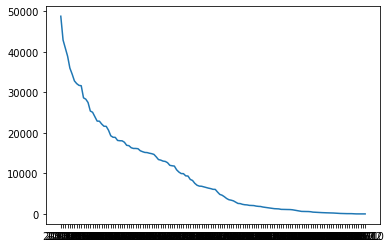

In [60]:
plt.plot(df_accepted['issue_d'].value_counts())

In [61]:
df_accepted[df_accepted['issue_d'].str.startswith('2009')]['issue_d'].value_counts()

200912    597
200911    595
200910    543
200909    445
200908    407
200907    372
200906    353
200905    319
200904    287
200903    275
200902    259
200901    236
Name: issue_d, dtype: int64

##Creating a Neural Network Model

now we are ready to start our modelling phase. First, let's apply a train-test-split and scale data before training.

In [62]:
X = {}
Y = {}

In [63]:
# sampling data

# df = df_accepted.sample(frac=0.8,random_state=42)
# print(len(df))

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:215: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [64]:
X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values

In [65]:
for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [66]:
X[2010].shape

(11497, 81)

## Deep Learning 모델

In [ ]:
import os.path 

def build_model_dl(year,x,y,epochs=5):
    #X_train, X_test, y_train, y_test = train_test_split(X[year], Y[year], test_size=0.2, random_state=42)
    X_train= scaler.fit_transform(x)
    #X_test = scaler.transform(X_test)
    y_train = get_one_hot(y,2)

    # building the model
    model = Sequential()
    model.add(Dense(units=78,activation='relu'))
    model.add(Dense(units=39,activation='relu'))
    model.add(Dense(units=19,activation='relu'))
    model.add(Dense(units=8,activation='relu'))
    model.add(Dense(units=4,activation='relu'))
    model.add(Dense(units=2,activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    weight_path = '/content/drive/MyDrive/Drift/model/ml_'+str(year)
    if os.path.exists(weight_path+'.index'):
        model.load_weights(weight_path)
        print('load weights from ',weight_path)
    else:
        model.fit(x=X_train, 
                y=y_train, 
                epochs=epochs,
                batch_size=512,
                verbose=1)
            #validation_data=(X_test, y_test), verbose=1)
        if year > 2000:
            model.save_weights(weight_path) 
            print('save weights to ',weight_path)
    return model

## Random forest model

각 년도별 학습

In [67]:
ML = {}
scaler = MinMaxScaler()

In [68]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [69]:
MODEL_TYPE = 'RF'  ## RF / DL

In [70]:
from sklearn.ensemble import RandomForestClassifier

def build_model_rf(year,x,y,epochs=5):
    X_train= scaler.fit_transform(x)
    y_train = y #get_one_hot(y,2)
    model = RandomForestClassifier(n_estimators=80,max_depth=5)
    model.fit(x,y)
    return model

## 년도별 모델 빌드

In [71]:
%rm -f /content/drive/MyDrive/Drift/model/checkpoint

def build_models():
    for year in range(2009,2019):
        # building the model
        print(str(year) + '년도 학습 ======================================')
        epochs = 100 #(100 if year==2009 else 5)
        if MODEL_TYPE =='DL':
            ML[year] = build_model_dl(year,X[year],Y[year],epochs=epochs)
        else:
            ML[year] = build_model_rf(year,X[year],Y[year],epochs=epochs)
            

In [72]:
build_models()

2009년도 학습 ======================================
2010년도 학습 ======================================
2011년도 학습 ======================================
2012년도 학습 ======================================
2013년도 학습 ======================================
2014년도 학습 ======================================
2015년도 학습 ======================================
2016년도 학습 ======================================
2017년도 학습 ======================================
2018년도 학습 ======================================


## Evaluate model

In [ ]:
metric = np.zeros((10,10))
mdf = pd.DataFrame(metric,columns=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'],index=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'])


In [ ]:
# 2009년 학습으로 2010~2018년까지의 acc 비교
for model_year in range(2009,2019):
    print('model:',model_year)
    for year in range(2009,2019):
        print('\ttest:',year)
        X_test = scaler.fit_transform(X[year])
        if MODEL_TYPE =='DL':
            predictions = (ML[model_year].predict(X_test)[:,1] > 0.5).astype("int32")
        else:
            predictions = (ML[model_year].predict(X_test) > 0.5).astype("int32")
        acc = accuracy_score(Y[year], predictions)
        print('\tacc:',acc)
        mdf.iloc[year-2009,model_year-2009] = acc

mdf

model: 2009
	test: 2009
	acc: 0.8971882007935139
	test: 2010
	acc: 0.9011916152039663
	test: 2011
	acc: 0.8858131487889274
	test: 2012
	acc: 0.8976342470897484
	test: 2013
	acc: 0.9080043973675219
	test: 2014
	acc: 0.8958675534731759
	test: 2015
	acc: 0.8793509789702683
	test: 2016
	acc: 0.8564470061057996
	test: 2017
	acc: 0.8468939875391258
	test: 2018
	acc: 0.8748672343336513
model: 2010
	test: 2009
	acc: 0.8813179230636536
	test: 2010
	acc: 0.8815343132991215
	test: 2011
	acc: 0.8591003460207612
	test: 2012
	acc: 0.852628614344724
	test: 2013
	acc: 0.8632730676095256
	test: 2014
	acc: 0.8440055290770211
	test: 2015
	acc: 0.8309889945826047
	test: 2016
	acc: 0.801960012998341
	test: 2017
	acc: 0.7973534006070073
	test: 2018
	acc: 0.8629858323282147
model: 2011
	test: 2009
	acc: 0.9015007762635846
	test: 2010
	acc: 0.907541097677655
	test: 2011
	acc: 0.8972087658592849
	test: 2012
	acc: 0.9094442358242584
	test: 2013
	acc: 0.9228677967108879
	test: 2014
	acc: 0.9186974356212583
	test

2009      2010      2011      2012      2013      2014      2015  \
2009  0.897188  0.881318  0.901501  0.901328  0.917716  0.909953  0.871830   
2010  0.901192  0.881534  0.907541  0.907454  0.926677  0.917805  0.876142   
2011  0.885813  0.859100  0.897209  0.897116  0.920738  0.911096  0.851903   
2012  0.897634  0.852629  0.909444  0.909519  0.935674  0.924803  0.842546   
2013  0.908004  0.863273  0.922868  0.922883  0.942470  0.936602  0.850207   
2014  0.895868  0.844006  0.918697  0.918572  0.935379  0.929217  0.827136   
2015  0.879351  0.830989  0.903295  0.903335  0.923749  0.916694  0.813089   
2016  0.856447  0.801960  0.883531  0.883189  0.903720  0.896513  0.782842   
2017  0.846894  0.797353  0.868608  0.868412  0.882447  0.877969  0.779232   
2018  0.874867  0.862986  0.880430  0.880448  0.882842  0.882428  0.853139   

          2016      2017      2018  
2009  0.929619  0.410212  0.869760  
2010  0.938854  0.421153  0.867879  
2011  0.937855  0.413333  0.846690  
2012  0.945851  0.438922  0.839016  
2013  0.945196  0.489289  0.850720  
2014  0.942241  0.488641  0.830820  
2015  0.931283  0.503167  0.826531  
2016  0.913014  0.537078  0.803800  
2017  0.892610  0.539114  0.790214  
2018  0.887955  0.555294  0.849736

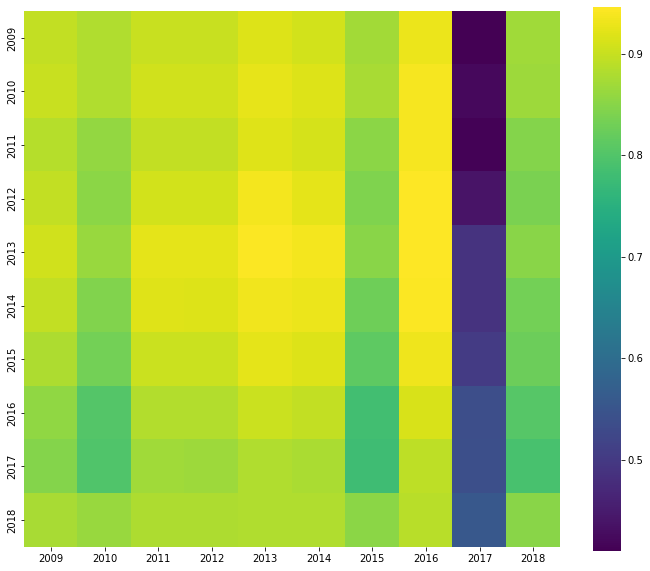

In [ ]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(mdf)
mask[np.triu_indices_from(mask)] = False
sns.heatmap(mdf, cmap='viridis', mask=mask, annot=False, square=True)

## shap에 의한 feature importance 분석

In [ ]:
import shap
import sys
from alibi_detect.cd import ChiSquareDrift, KSDrift, ClassifierDrift

In [ ]:
REFERENCE_YEAR = 2009

In [ ]:
x_columns = list(df_accepted.columns)
x_columns.remove('loan_paid')
x_columns.remove('issue_d')

In [ ]:
def XAI(model,X_test,top=6):

    XAI_Explainer = None
    if MODEL_TYPE == 'DL':
        XAI_Explainer = shap.DeepExplainer
        xs = X_test[0:10]
        model(X_test)
    else:
        XAI_Explainer = shap.TreeExplainer
        xs = X_test

    explainer = XAI_Explainer(model,X_test)
    
    shap_values = explainer.shap_values(xs)
    vals= np.abs(shap_values).mean(0)*2
    feature_importance = {}
    for (fname,imp_val) in zip(x_columns,np.mean(vals,axis=0)):
        feature_importance[fname] = (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)

    sorted_feature = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0],reverse=True)}
    
    monitoring_feature = np.array(list(sorted_feature.keys()))[0:top]
    return feature_importance, monitoring_feature, shap_values

In [ ]:
def get_feature_importance(model,X_test,display=False):
    #model = ML[year]
    X_test = scaler.fit_transform(X_test)

    # ##### EXPLANATIONS #####
    print()
    print("Generating explanations...")
    
    df_x_test = pd.DataFrame(X_test,columns=x_columns)

    feature_importance, monitoring_feature, shap_values = XAI(model,X_test,top=5)
    print('monitoring_feature',monitoring_feature)
    if display:
        plt.figure(figsize=(30,15))
        shap.summary_plot(shap_values, df_x_test, show=False, class_names=['Fully pad','charge-off'])
        plt.grid()
        plt.savefig('SHAP_EXPLANATIONS.png', bbox_inches='tight')
        plt.show()
    return feature_importance, monitoring_feature


Generating explanations...
monitoring_feature ['recoveries' 'Verified' 'debt_consolidation' 'RENT' 'Source Verified']


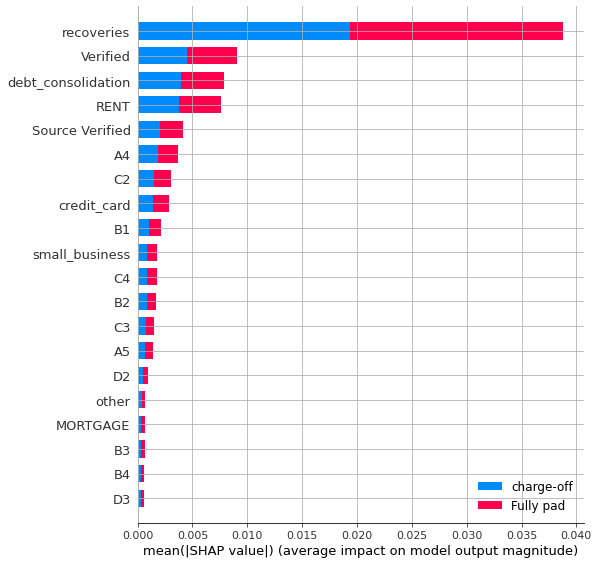

In [ ]:
feature_importance, monitoring_feature = get_feature_importance(ML[REFERENCE_YEAR],X[REFERENCE_YEAR],display=True)

In [ ]:
model = ML[REFERENCE_YEAR]

importances = model.feature_importances_
forest_importances = pd.Series(importances, index=x_columns)

feature_importance = {}
for (fname,imp_val) in forest_importances.items():
    feature_importance[fname] = (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)


list(forest_importances.sort_values(ascending=False).keys()[0:5])

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'total_rec_int']

## Data drift에 의한 모델의 성능 추정 방법
### sudo code

In [ ]:
Trainset : y=f(x)

base_f1 = f1 score of base model
f1= []
xd = []
for n fold:
    y_ref, y_inf, x_ref, x_inf = split(y, x, a)
    f1_ref = f1(y_ref, predit(x_ref))
    f1_inf = f1(y_inf, predit(x_inf))
    f1_delta = f1_inf  - f1_ref
    if f1_delta < 0:
        x_drift = drift(x_ref, x_inf)
        f1.add(f1_delta)
        xd.add(x_drift)

model_predict_f1_from_drift = train(f1,xd)

x_live = Inference data from time1 to time2
x_live_drift = drift(x, x_live)
predit_f1 = base_f1 + model_predict_f1_from_drift(x_live_drift)

In [77]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

#base_f1 = precision_recall_fscore_support(Y[2010],ML[2010].predict(X[2010]),average='binary')
base_f1 = f1_score(Y[2010],ML[2010].predict(X[2010]),average='binary')

In [78]:
base_f1

0.9953382265423527

In [79]:
from scipy.stats import ks_2samp

def drift(ref_x,inf_x):
    x_drift = np.zeros(ref_x.shape[1])
    for i in range(ref_x.shape[1]):
        s, p = ks_2samp(ref_x[:,i],inf_x[:,i])
        x_drift[i] = s

    return x_drift

In [116]:
from sklearn.model_selection import train_test_split

y = Y[2010]
x = X[2010]
predict = ML[2010].predict
base_f1 = []
f1= []
xd = []
for i in range(1000):
    y_ref, y_inf, x_ref, x_inf = train_test_split(y, x, test_size=0.5, random_state=i)
    f1_ref = f1_score(y_ref, predict(x_ref))
    f1_inf = f1_score(y_inf, predict(x_inf))
    base_f1.append(max([f1_ref,f1_inf]))
    f1_delta = f1_ref - f1_inf
    if f1_delta > 0:
        x_drift = drift(x_ref, x_inf)
    else:
        x_drift = drift(x_inf, x_ref)

    print(f'\r{i+1}/1000 f1_delta:{f1_delta}', end="", flush=True)

    f1.append(abs(f1_delta))
    xd.append(x_drift)

base_f1 = np.mean(base_f1)
f1 = np.asarray(f1)        
xd = np.asarray(xd)


1000/1000 f1_delta:0.0007870203329327641

In [128]:
base_f1

0.9957237369698355

In [118]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical

In [91]:
from keras import backend as K


def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

In [122]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(xd.shape[1], activation='relu'),
    tf.keras.layers.Dense(xd.shape[1]*2, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

In [123]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=[r2])

In [124]:
model.fit(xd, f1, batch_size=50, epochs=2000)

Epoch 1/2000
20/20 [==============================] - 0s 2ms/step - loss: 7.1078e-06 - r2: -19.6186
Epoch 2/2000
20/20 [==============================] - 0s 2ms/step - loss: 1.0155e-06 - r2: -2.4709
Epoch 3/2000
20/20 [==============================] - 0s 2ms/step - loss: 5.5550e-07 - r2: -0.6927
Epoch 4/2000
20/20 [==============================] - 0s 2ms/step - loss: 4.2905e-07 - r2: -0.3007
Epoch 5/2000
20/20 [==============================] - 0s 2ms/step - loss: 4.0784e-07 - r2: -0.2312
Epoch 6/2000
20/20 [==============================] - 0s 2ms/step - loss: 3.9015e-07 - r2: -0.1580
Epoch 7/2000
20/20 [==============================] - 0s 2ms/step - loss: 3.7860e-07 - r2: -0.1309
Epoch 8/2000
20/20 [==============================] - 0s 2ms/step - loss: 4.6147e-07 - r2: -0.4007
Epoch 9/2000
20/20 [==============================] - 0s 2ms/step - loss: 5.4015e-07 - r2: -0.7494
Epoch 10/2000
20/20 [==============================] - 0s 2ms/step - loss: 4.0679e-07 - r2: -0.2057
Epoch 11

In [125]:
model.predict(xd[0].reshape(1,-1))[0,0]

0.0004289964

In [130]:
import math

batch_size = 10000
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017],X[2018]))
Y2 = np.concatenate((Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017],Y[2018]))

batch = math.ceil(X2.shape[0]/batch_size)
df = {}
df['f1'] = []
df['f1_predict'] = []

for i in range(batch):
    X3 = X2[i*batch_size:(i+1)*batch_size]
    Y3 = Y2[i*batch_size:(i+1)*batch_size]
    f1 = f1_score(Y3, predict(X3))
    X3_drift = drift(X[2010],X3)
    f1_predict = base_f1 - abs(model.predict(X3_drift.reshape(1,-1))[0,0])
    print(f"{f1}, {f1_predict}")
    df['f1'].append(f1)
    df['f1_predict'].append(f1_predict)

df1 = pd.DataFrame(df)

df1

0.9961021583570888, 0.9882147782799671
0.9959202979956246, 0.9758468917888472
0.9944542772861357, 0.9942253541984478
0.9934851473313011, 0.9908260004912386
0.9934867045115028, 0.9956548591752885
0.9937720329024677, 0.9924970518649439
0.9907602339181286, 0.9953213477882905
0.9920047031158141, 0.986972842862911
0.9905218815820268, 0.9861900066343019
0.9908842826452999, 0.9943468543087015
0.9895515379196995, 0.9949778430481324
0.9889743131295071, 0.9887686106693814
0.989993563110773, 0.9857664467153022
0.9892384592766833, 0.9853900024053523
0.9913094196558763, 0.9924478575439075
0.9876557723959558, 0.9873657501620123
0.9882573978393612, 0.9884831239786813
0.9884534639608117, 0.9844130748269031
0.9873078714485327, 0.984281448213465
0.987124963588698, 0.9835971906167338
0.9877336448598131, 0.981069813979871
0.9830034924330616, 0.982441257251508
0.9789202482726314, 0.9821485313904355
0.9714785651793526, 0.9822393027451704
0.9713851903760804, 0.9698266252261469
0.9685882352941176, 0.972467595

f1  f1_predict
0    0.996102    0.988215
1    0.995920    0.975847
2    0.994454    0.994225
3    0.993485    0.990826
4    0.993487    0.995655
..        ...         ...
128  0.924104    0.971538
129  0.919266    0.983135
130  0.923363    0.994941
131  0.962625    0.990223
132  0.994070    0.988182

[133 rows x 2 columns]

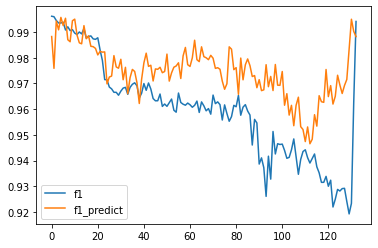

In [131]:
df1.plot()

## Drift 측정

Reference년도의 train data를 기준으로 
bucket size, step size 를 변경하면서 
KS drift를 측정한다!

In [ ]:
import pickle

def scan_data(detect_p_val=1e-6,is_do_retrain=True):
    # 기준 년도의 모델
    model = ML[REFERENCE_YEAR]
    # 기준 년도의 데이터
    df_reference = df_accepted[df_accepted['issue_d'].str.startswith(str(REFERENCE_YEAR))]
    start_index = df_reference.index[0]
    # reference drift 데이터
    drift_ref = df_reference[monitoring_feature].values
    # data drift detect...
    #detect_p_val = 1e-6 if MODEL_TYPE =='DL' else 2e-1
    cd = KSDrift(drift_ref, p_val=detect_p_val)

    #is_do_retrain = True

    # 초기 버퍼들 준비
    result_data = {}
    result_data['model performance'] = []
    result_data['model confidence'] = []
    for column in monitoring_feature:
        result_data[column + ' '] = []
        result_data[column + ' Drift'] = []
        result_data[column + ' p_val'] = []
    drift_point = {} # feature_name:[(x,y),p_val]
    drift_status = []
    distribution_analysis = []

    bucket_size = 10000
    step = 1000
    retrain_count = 0
    now = 0

    # 앞으로 비교 진행해야 할 대상 데이터, reference년도의 10월부터의 데이터...
    df_for_drift = df_accepted[df_accepted['issue_d']>=str(REFERENCE_YEAR) + '10']
    df_for_drift = df_for_drift[df_for_drift.index <=1285476]
    
    #print(len(df_for_drift))
    print('='*30 + ' Drift detect from year '+str(REFERENCE_YEAR) + ' '+'='*30)
    for i in range(0,df_for_drift.shape[0],step):
        
        now +=1
        cutoff = (i + bucket_size) if (i + bucket_size) < df_for_drift.shape[0] else df_for_drift.shape[0]
        df_x_test = df_for_drift[i:cutoff]

        current_index = df_x_test.index[-1]
        current_day = df_x_test['issue_d'].values[0]

        y_test = df_x_test.loan_paid.values
        df_x_test_without_label = df_x_test.drop(columns=['issue_d','loan_paid'])
        x_test_for_model = df_x_test_without_label.values
        x_test_for_drift = df_x_test_without_label[monitoring_feature].to_numpy()
        
        preds = cd.predict(x_test_for_drift, drift_type='batch', return_p_val=True, return_distance=True)
        fpreds = cd.predict(x_test_for_drift, drift_type='feature')
        is_drift_count = 0
        for f in range(cd.n_features):
            stat = 'K-S'
            fname = monitoring_feature[f]
            is_drift = fpreds['data']['is_drift'][f]
            if is_drift:
                is_drift_count +=1
            stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
            #print(f'{fname}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}') 
            result_data[fname + ' '].append(stat_val)
            result_data[fname + ' Drift'].append(is_drift)
            result_data[fname + ' p_val'].append(p_val)

            (f_importance_value, f_drift, f_p_val, f_is_drift) = feature_importance[fname]
            f_drift = stat_val
            f_p_val = p_val
            f_is_drift = is_drift
            feature_importance[fname] = (f_importance_value, f_drift, f_p_val, f_is_drift) 

            if is_drift and fname+str(retrain_count) not in drift_point:
                drift_point[fname+str(retrain_count)] = [(len(result_data[fname + ' '])-1,stat_val),p_val]

        drift_status.append(feature_importance.copy())
        distribution_analysis.append(x_test_for_drift.copy())
        predict_out = model.predict(scaler.fit_transform(x_test_for_model))
        #print(predict_out)
        
        if MODEL_TYPE =='DL':
            confidence = np.mean(np.array(predict_out).max(axis=1))
            y_pred_datadrift = (predict_out[:,1] > 0.5).astype("int32")
        else:
            confidence = np.mean(np.abs(predict_out - 0.5) + 0.5)
            y_pred_datadrift = (predict_out > 0.5).astype("int32")
        
        datadrift_test_acc = accuracy_score(y_test,y_pred_datadrift)
        #print("Datadrift_Test_Accuracy: ",datadrift_test_acc)
        result_data['model performance'].append(datadrift_test_acc)
        result_data['model confidence'].append(confidence)
        print(f'\r {i}/{df_for_drift.shape[0]} step {now} day {current_day} index {current_index} model_ver {retrain_count} drift {is_drift_count} acc {datadrift_test_acc:.4f} cfd {confidence:.4f}', end="", flush=True)

        if is_drift_count == len(monitoring_feature) and is_do_retrain:
            
            print()
            #del model
            del cd
            #print('Delete model...')
            print("="*50 + " Train " + "="*50)
            #new_sample = df_for_drift[df_for_drift.index<=current_index][-len(X_train):]
            mask = (df_accepted.index>=start_index) & (df_accepted.index<=current_index)
            df_reference = df_accepted.loc[mask]
            print(f'new reference data index {start_index}~{current_index}, length {len(df_reference)}')
            # reference drift 데이터
            drift_ref = df_reference[monitoring_feature].values
            cd = KSDrift(drift_ref, p_val=detect_p_val)
            y = df_reference.loan_paid.values
            x = df_reference.drop(columns=['issue_d','loan_paid']).to_numpy()
            if MODEL_TYPE =='DL':
                model = build_model_dl(1000+retrain_count,x,y,epochs=100)
            else:
                model = build_model_rf(1000+retrain_count,x,y,epochs=100)
            retrain_count += 1
            print()


    with open("/content/drive/MyDrive/Drift/drift_result_data.bin", "wb") as fp:
        pickle.dump([result_data,drift_point,drift_status,distribution_analysis],fp)

    return [result_data,drift_point,drift_status,distribution_analysis,start_index,current_index,detect_p_val]

## image 저장 도구들

In [ ]:
import pickle
with open("/content/drive/MyDrive/Drift/drift_result_data.bin", "rb") as fp:
    a = pickle.load(fp)
    result_data = a[0]
    drift_point = a[1]
    drift_status = a[2]
    distribution_analysis = a[3]

In [ ]:

import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import glob

def generate_gif(path,output_file_name = 'out.gif'):
    img_list = os.listdir(path)
    img_list = [path + '/' + x for x in img_list if x.endswith(".png")]
    images = [Image.open(x) for x in img_list]
    
    im = images[0]
    im.save('out.gif', save_all=True, append_images=images[1:],loop=0xff, duration=200)
    # loop 반복 횟수
    # duration 프레임 전환 속도 (500 = 0.5초)
    return Img(url=output_file_name)

In [ ]:
%rm -f /content/drive/MyDrive/Drift/img/*.png

for cut in range(0,len(drift_status),10):

    status = drift_status[cut]
    drifted_columns = []
    fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(10,10) )  # create figure & 1 axis
    fig.suptitle('Feature importance vs Drift at time '+str(cut))
    plt.xlabel('Feature importance')
    plt.ylabel('Drift KPI')
    for fname in status.keys():
        (importance_value, drift, p_val, is_drift) = status[fname]
        if is_drift:
            drifted_columns.append(fname)
        ax.annotate(fname+':'+str(is_drift), (importance_value,drift),color=('red' if is_drift==1 else 'black'))
        ax.plot([importance_value],[drift],'o')
        ax.grid()
    fig.savefig('/content/drive/MyDrive/Drift/img/IvD_'+str(cut)+'.png')   # save the figure to file
    plt.close(fig)    # close the figure window

In [ ]:
gif = generate_gif('/content/drive/MyDrive/Drift/img')

## 측정의 chart 출력

In [ ]:
def plot_drift(scan_result,span = 10):

    result_data = scan_result[0]
    drift_point = scan_result[1]
    drift_status = scan_result[2]
    distribution_analysis = scan_result[3]
    start_index = scan_result[4]
    end_index = scan_result[5]
    p_val = scan_result[6]
    monitoring_feature = scan_result[7]
    feature_importance = scan_result[8]
    plt.style.use('bmh')
    #span = 10
    df_result = pd.DataFrame(result_data).dropna(axis=1,how='all')
    df_fi = pd.DataFrame(feature_importance).dropna(axis=1,how='all')

    ax = df_result.drop(columns=['model performance','model confidence']).ewm(span = span).mean().plot(linewidth=1,figsize=(20,10))
    #ax.plot(df_fi.ewm(span = 10).mean(),linewidth=1)
    df_fi.ewm(span = 10).mean().plot(linewidth=1,figsize=(20,10),linestyle='--',ax=ax)
    ax.set_title(f"ref_year {REFERENCE_YEAR} model {MODEL_TYPE} p_value {p_val} between {df_accepted[df_accepted.index==start_index]['issue_d'].values[0]}~{df_accepted[df_accepted.index==end_index]['issue_d'].values[0]}")
    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel("Drift / Feature importance")
    for fname in drift_point.keys():
        if fname.startswith(tuple(monitoring_feature)):
            p,p_val = drift_point[fname]
            plt.annotate(str(p_val), (p[0]-5,p[1]+0.02))
            plt.plot([p[0]],[p[1]],'o')
    ax_perf = ax.twinx()
    ax_perf.set_ylim(0.70, 1.0)
    ax_perf.set_ylabel("model performance")
    ax_perf.plot(df_result['model performance'].ewm(span = span).mean(),linewidth=2,label='model performance')
    ax_perf.plot(df_result['model confidence'].ewm(span = span).mean(),linewidth=1,label='model confidence')
    ax_perf.legend()
    #ax = result_df['model performance'].ewm(span = 10).mean().plot(linewidth=1,figsize=(20,10))
    ax.legend(bbox_to_anchor=(0.0, 1.0))
    ax.plot()
    plt.show()




In [ ]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

## 실험들

### scan_data 여러가지들...

In [ ]:
import pickle

def scan_data2(detect_p_val=1e-6,is_do_retrain=True):
    # 기준 년도의 모델
    model = ML[REFERENCE_YEAR]

    importances = model.feature_importances_
    forest_importances = pd.Series(importances, index=x_columns)

    feature_importance = {}
    for (fname,imp_val) in forest_importances.items():
        feature_importance[fname] = (imp_val,0,0,0) 
    monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:5])
    print('monitoring_feature',monitoring_feature)
    #feature_importance, monitoring_feature = get_feature_importance(ML[REFERENCE_YEAR],X[REFERENCE_YEAR])

    # 기준 년도의 데이터
    df_reference = df_accepted[df_accepted['issue_d'].str.startswith(str(REFERENCE_YEAR))]
    start_index = df_reference.index[0]
    # reference drift 데이터
    drift_ref = df_reference[monitoring_feature].values
    # data drift detect...
    #detect_p_val = 1e-6 if MODEL_TYPE =='DL' else 2e-1
    cd = KSDrift(drift_ref, p_val=detect_p_val)
    #model_cd = ClassifierDrift(scaler.fit_transform(df_reference.drop(columns=['issue_d','loan_paid']).values), model, p_val=.05, train_size=.75, epochs=1)

    #is_do_retrain = True

    # 초기 버퍼들 준비
    result_data = {}
    result_data['model performance'] = []
    result_data['model confidence'] = []
    for column in x_columns:
        result_data[column] = []
        #result_data[column + ' Drift'] = []
        #result_data[column + ' p_val'] = []
    drift_point = {} # feature_name:[(x,y),p_val]
    drift_status = []
    distribution_analysis = []

    bucket_size = 10000
    step = 5000
    retrain_count = 0
    now = 0

    # 앞으로 비교 진행해야 할 대상 데이터, reference년도의 10월부터의 데이터...
    df_for_drift = df_accepted[df_accepted['issue_d']>=str(REFERENCE_YEAR) + '10']
    df_for_drift = df_for_drift[df_for_drift.index <=1285476]
    
    #print(len(df_for_drift))
    print('='*30 + ' Drift detect from year '+str(REFERENCE_YEAR) + ' '+'='*30)
    for i in range(0,df_for_drift.shape[0],step):
        
        now +=1
        cutoff = (i + bucket_size) if (i + bucket_size) < df_for_drift.shape[0] else df_for_drift.shape[0]
        df_x_test = df_for_drift[i:cutoff]

        current_index = df_x_test.index[-1]
        current_day = df_x_test['issue_d'].values[0]

        y_test = df_x_test.loan_paid.values
        df_x_test_without_label = df_x_test.drop(columns=['issue_d','loan_paid'])
        x_test_for_model = df_x_test_without_label.values
        x_test_for_drift = df_x_test_without_label[monitoring_feature].to_numpy()
        
        preds = cd.predict(x_test_for_drift, drift_type='batch', return_p_val=True, return_distance=True)
        fpreds = cd.predict(x_test_for_drift, drift_type='feature')
        is_drift_count = 0
        for f in range(cd.n_features):
            stat = 'K-S'
            fname = monitoring_feature[f]
            is_drift = fpreds['data']['is_drift'][f]
            if is_drift:
                is_drift_count +=1
            stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
            #print(f'{fname}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}') 
            result_data[fname].append(stat_val)
            #result_data[fname + ' Drift'].append(is_drift)
            #result_data[fname + ' p_val'].append(p_val)

            (f_importance_value, f_drift, f_p_val, f_is_drift) = feature_importance[fname]
            f_drift = stat_val
            f_p_val = p_val
            f_is_drift = is_drift
            feature_importance[fname] = (f_importance_value, f_drift, f_p_val, f_is_drift) 
            if is_drift and fname+str(retrain_count) not in drift_point:
                drift_point[fname+str(retrain_count)] = [(len(result_data[fname])-1,stat_val),p_val]

        for fname in x_columns:
            if fname not in monitoring_feature:
                result_data[fname].append(None)
                #result_data[fname + ' Drift'].append(None)
                #result_data[fname + ' p_val'].append(None)

        drift_status.append(feature_importance.copy())
        distribution_analysis.append(x_test_for_drift.copy())

        x_h0 = scaler.fit_transform(x_test_for_model)
        '''
        preds = model_cd.predict(x_h0)
        print(preds)
        '''
        predict_out = model.predict(x_h0)

        #print(predict_out)
        
        if MODEL_TYPE =='DL':
            confidence = np.mean(np.array(predict_out).max(axis=1))
            y_pred_datadrift = (predict_out[:,1] > 0.5).astype("int32")
        else:
            confidence = np.mean(np.abs(predict_out - 0.5) + 0.5)
            y_pred_datadrift = (predict_out > 0.5).astype("int32")
        
        datadrift_test_acc = accuracy_score(y_test,y_pred_datadrift)
        #print("Datadrift_Test_Accuracy: ",datadrift_test_acc)
        result_data['model performance'].append(datadrift_test_acc)
        result_data['model confidence'].append(confidence)
        print(f'\r {i}/{df_for_drift.shape[0]} step {now} day {current_day} index {current_index} model_ver {retrain_count} drift {is_drift_count} acc {datadrift_test_acc:.4f} cfd {confidence:.4f}', end="", flush=True)

        if is_drift_count == len(monitoring_feature) and is_do_retrain:
            
            print()
            #del model
            del cd
            #print('Delete model...')
            print("="*50 + " Train " + "="*50)
            #new_sample = df_for_drift[df_for_drift.index<=current_index][-len(X_train):]
            mask = (df_accepted.index>=start_index) & (df_accepted.index<=current_index)
            df_reference = df_accepted.loc[mask]
            print(f'new reference data index {start_index}~{current_index}, length {len(df_reference)}')

            '''
            # ref year의 데이터와 최근 20만건의 데이터를 합하여, 썩는다.
            df_model_ref = pd.concat([df_accepted[df_accepted['issue_d'].str.endswith(str(REFERENCE_YEAR))],df_reference[-200000:]])
            df_model_ref = df_model_ref.sample(frac=1)
            '''
            y = df_reference.loan_paid.values
            x = df_reference.drop(columns=['issue_d','loan_paid']).to_numpy()
            if MODEL_TYPE =='DL':
                model = build_model_dl(1000+retrain_count,x,y,epochs=100)
            else:
                model = build_model_rf(1000+retrain_count,x,y,epochs=100)

            importances = model.feature_importances_
            forest_importances = pd.Series(importances, index=x_columns)
            monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:5])
            print('monitoring_feature',monitoring_feature)
            # reference drift 데이터
            drift_ref = df_reference[monitoring_feature].to_numpy()[-100000:]
            cd = KSDrift(drift_ref, p_val=detect_p_val)            
            retrain_count += 1
            print()


    with open("/content/drive/MyDrive/Drift/drift_result_data.bin", "wb") as fp:
        pickle.dump([result_data,drift_point,drift_status,distribution_analysis],fp)

    return [result_data,drift_point,drift_status,distribution_analysis,start_index,current_index,detect_p_val]

In [ ]:
import pickle

def scan_data3(detect_p_val=1e-6,is_do_retrain=True):
    # 기준 년도의 모델
    model = ML[REFERENCE_YEAR]

    importances = model.feature_importances_
    forest_importances = pd.Series(importances, index=x_columns)

    feature_importance = {}
    for (fname,imp_val) in forest_importances.items():
        feature_importance[fname] = (imp_val,0,0,0) 
    monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:5])
    print('monitoring_feature',monitoring_feature)
    #feature_importance, monitoring_feature = get_feature_importance(ML[REFERENCE_YEAR],X[REFERENCE_YEAR])

    # 기준 년도의 데이터
    df_reference = df_accepted[df_accepted['issue_d'].str.startswith(str(REFERENCE_YEAR))]
    start_index = df_reference.index[0]
    # reference drift 데이터
    drift_ref = df_reference[monitoring_feature].values
    # data drift detect...
    #detect_p_val = 1e-6 if MODEL_TYPE =='DL' else 2e-1
    cd = KSDrift(drift_ref, p_val=detect_p_val)
    #model_cd = ClassifierDrift(scaler.fit_transform(df_reference.drop(columns=['issue_d','loan_paid']).values), model, p_val=.05, train_size=.75, epochs=1)

    #is_do_retrain = True

    # 초기 버퍼들 준비
    result_data = {}
    result_data['model performance'] = []
    result_data['model confidence'] = []
    for column in x_columns:
        result_data[column] = []
        #result_data[column + ' Drift'] = []
        #result_data[column + ' p_val'] = []
    drift_point = {} # feature_name:[(x,y),p_val]
    drift_status = []
    distribution_analysis = []

    bucket_size = 10000
    step = 5000
    retrain_count = 0
    now = 0

    # 앞으로 비교 진행해야 할 대상 데이터, reference년도의 10월부터의 데이터...
    df_for_drift = df_accepted[df_accepted['issue_d']>=str(REFERENCE_YEAR) + '10']
    df_for_drift = df_for_drift[df_for_drift.index <=1285476]
    
    #print(len(df_for_drift))
    print('='*30 + ' Drift detect from year '+str(REFERENCE_YEAR) + ' '+'='*30)
    for i in range(0,df_for_drift.shape[0],step):
        
        now +=1
        cutoff = (i + bucket_size) if (i + bucket_size) < df_for_drift.shape[0] else df_for_drift.shape[0]
        df_x_test = df_for_drift[i:cutoff]

        current_index = df_x_test.index[-1]
        current_day = df_x_test['issue_d'].values[0]

        y_test = df_x_test.loan_paid.values
        df_x_test_without_label = df_x_test.drop(columns=['issue_d','loan_paid'])
        x_test_for_model = df_x_test_without_label.values
        x_test_for_drift = df_x_test_without_label[monitoring_feature].to_numpy()
        
        preds = cd.predict(x_test_for_drift, drift_type='batch', return_p_val=True, return_distance=True)
        fpreds = cd.predict(x_test_for_drift, drift_type='feature')
        is_drift_count = 0
        for f in range(cd.n_features):
            stat = 'K-S'
            fname = monitoring_feature[f]
            is_drift = fpreds['data']['is_drift'][f]
            if is_drift:
                is_drift_count +=1
            stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
            #print(f'{fname}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}') 
            result_data[fname].append(stat_val)
            #result_data[fname + ' Drift'].append(is_drift)
            #result_data[fname + ' p_val'].append(p_val)

            (f_importance_value, f_drift, f_p_val, f_is_drift) = feature_importance[fname]
            f_drift = stat_val
            f_p_val = p_val
            f_is_drift = is_drift
            feature_importance[fname] = (f_importance_value, f_drift, f_p_val, f_is_drift) 
            if is_drift and fname+str(retrain_count) not in drift_point:
                drift_point[fname+str(retrain_count)] = [(len(result_data[fname])-1,stat_val),p_val]

        for fname in x_columns:
            if fname not in monitoring_feature:
                result_data[fname].append(None)
                #result_data[fname + ' Drift'].append(None)
                #result_data[fname + ' p_val'].append(None)

        drift_status.append(feature_importance.copy())
        distribution_analysis.append(x_test_for_drift.copy())

        x_h0 = scaler.fit_transform(x_test_for_model)
        '''
        preds = model_cd.predict(x_h0)
        print(preds)
        '''
        predict_out = model.predict(x_h0)

        #print(predict_out)
        
        if MODEL_TYPE =='DL':
            confidence = np.mean(np.array(predict_out).max(axis=1))
            y_pred_datadrift = (predict_out[:,1] > 0.5).astype("int32")
        else:
            confidence = np.mean(np.abs(predict_out - 0.5) + 0.5)
            y_pred_datadrift = (predict_out > 0.5).astype("int32")
        
        datadrift_test_acc = accuracy_score(y_test,y_pred_datadrift)
        #print("Datadrift_Test_Accuracy: ",datadrift_test_acc)
        result_data['model performance'].append(datadrift_test_acc)
        result_data['model confidence'].append(confidence)
        print(f'\r {i}/{df_for_drift.shape[0]} step {now} day {current_day} index {current_index} model_ver {retrain_count} drift {is_drift_count} acc {datadrift_test_acc:.4f} cfd {confidence:.4f}', end="", flush=True)

        if is_drift_count == len(monitoring_feature) and is_do_retrain:
            
            print()
            #del model
            del cd
            #print('Delete model...')
            print("="*50 + " Train " + "="*50)
            #new_sample = df_for_drift[df_for_drift.index<=current_index][-len(X_train):]
            mask = (df_accepted.index>=start_index) & (df_accepted.index<=current_index)
            df_reference = df_accepted.loc[mask]
            print(f'new reference data index {start_index}~{current_index}, length {len(df_reference)}')

            '''
            # ref year의 데이터와 최근 20만건의 데이터를 합하여, 썩는다.
            df_model_ref = pd.concat([df_accepted[df_accepted['issue_d'].str.endswith(str(REFERENCE_YEAR))],df_reference[-200000:]])
            df_model_ref = df_model_ref.sample(frac=1)
            '''
            df_ref_tmp = df_reference[-10000:]
            y = df_ref_tmp.loan_paid.values
            x = df_ref_tmp.drop(columns=['issue_d','loan_paid']).to_numpy()
            if MODEL_TYPE =='DL':
                model = build_model_dl(1000+retrain_count,x,y,epochs=100)
            else:
                model = build_model_rf(1000+retrain_count,x,y,epochs=100)

            importances = model.feature_importances_
            forest_importances = pd.Series(importances, index=x_columns)
            monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:5])
            print('monitoring_feature',monitoring_feature)

            # reference drift 데이터
            drift_ref = df_reference[monitoring_feature].to_numpy()[-100000:]
            cd = KSDrift(drift_ref, p_val=detect_p_val)

            retrain_count += 1
            print()


    with open("/content/drive/MyDrive/Drift/drift_result_data.bin", "wb") as fp:
        pickle.dump([result_data,drift_point,drift_status,distribution_analysis],fp)

    return [result_data,drift_point,drift_status,distribution_analysis,start_index,current_index,detect_p_val]

### scan_data 라스트 버전...

feature importance 측정

In [ ]:
def get_live_feature_importance(x,y,monitoring_feature):
    m = RandomForestClassifier(n_estimators=80,max_depth=5)
    m.fit(x[0:1000],y[0:1000])
    importances = m.feature_importances_
    forest_importances = pd.Series(importances, index=x_columns)
    fi = {}
    for k,v in forest_importances.items():
        if k in monitoring_feature:
            fi[k] = v
    return fi

In [ ]:
import pickle

def scan_data4(detect_p_val=1e-6,is_do_retrain=True):
    # 기준 년도의 모델
    model = ML[REFERENCE_YEAR]

    importances = model.feature_importances_
    forest_importances = pd.Series(importances, index=x_columns)
    '''
    feature_importance = {}
    for (fname,imp_val) in forest_importances.items():
        feature_importance[fname] = (imp_val,0,0,0) 
    '''
    feature_importance = {}
    monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:5])
    print('monitoring_feature',monitoring_feature)
    #feature_importance, monitoring_feature = get_feature_importance(ML[REFERENCE_YEAR],X[REFERENCE_YEAR])
    monitoring_features = []
    monitoring_features += monitoring_feature
    # 기준 년도의 데이터
    df_reference = df_accepted[df_accepted['issue_d'].str.startswith(str(REFERENCE_YEAR))]
    start_index = df_reference.index[0]
    # reference drift 데이터
    drift_ref = df_reference[monitoring_feature].values
    # data drift detect...
    #detect_p_val = 1e-6 if MODEL_TYPE =='DL' else 2e-1
    cd = KSDrift(drift_ref, p_val=detect_p_val)
    #model_cd = ClassifierDrift(scaler.fit_transform(df_reference.drop(columns=['issue_d','loan_paid']).values), model, p_val=.05, train_size=.75, epochs=1)

    #is_do_retrain = True

    # 초기 버퍼들 준비
    result_data = {}
    result_data['model performance'] = []
    result_data['model confidence'] = []
    for column in x_columns:
        result_data[column] = []
        feature_importance[column] = []
        #result_data[column + ' Drift'] = []
        #result_data[column + ' p_val'] = []
    
    drift_point = {} # feature_name:[(x,y),p_val]
    drift_status = []
    distribution_analysis = []

    bucket_size = 10000
    step = 5000
    retrain_count = 0
    now = 0

    # 앞으로 비교 진행해야 할 대상 데이터, reference년도의 10월부터의 데이터...
    df_for_drift = df_accepted[df_accepted['issue_d']>=str(REFERENCE_YEAR) + '10']
    df_for_drift = df_for_drift[df_for_drift.index <=1285476]
    
    #print(len(df_for_drift))
    print('='*30 + ' Drift detect from year '+str(REFERENCE_YEAR) + ' '+'='*30)
    for i in range(0,df_for_drift.shape[0],step):
        
        now +=1
        cutoff = (i + bucket_size) if (i + bucket_size) < df_for_drift.shape[0] else df_for_drift.shape[0]
        df_x_test = df_for_drift[i:cutoff]

        current_index = df_x_test.index[-1]
        current_day = df_x_test['issue_d'].values[0]

        y_test = df_x_test.loan_paid.values
        df_x_test_without_label = df_x_test.drop(columns=['issue_d','loan_paid'])
        x_test_for_model = df_x_test_without_label.values
        x_test_for_drift = df_x_test_without_label[monitoring_feature].to_numpy()
        
        preds = cd.predict(x_test_for_drift, drift_type='batch', return_p_val=True, return_distance=True)
        fpreds = cd.predict(x_test_for_drift, drift_type='feature')
        is_drift_count = 0
        for f in range(cd.n_features):
            stat = 'K-S'
            fname = monitoring_feature[f]
            is_drift = fpreds['data']['is_drift'][f]
            if is_drift:
                is_drift_count +=1
            stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
            #print(f'{fname}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}') 
            result_data[fname].append(stat_val)
            #result_data[fname + ' Drift'].append(is_drift)
            #result_data[fname + ' p_val'].append(p_val)
            '''
            (f_importance_value, f_drift, f_p_val, f_is_drift) = feature_importance[fname]
            f_drift = stat_val
            f_p_val = p_val
            f_is_drift = is_drift
            feature_importance[fname] = (f_importance_value, f_drift, f_p_val, f_is_drift) 
            '''
            if is_drift and fname+str(retrain_count) not in drift_point:
                drift_point[fname+str(retrain_count)] = [(len(result_data[fname])-1,stat_val),p_val]

        #drift_status.append(feature_importance.copy())
        distribution_analysis.append(x_test_for_drift.copy())

        x_h0 = scaler.fit_transform(x_test_for_model)
        '''
        preds = model_cd.predict(x_h0)
        print(preds)
        '''
        predict_out = model.predict(x_h0)

        #print(predict_out)
        
        if MODEL_TYPE =='DL':
            confidence = np.mean(np.array(predict_out).max(axis=1))
            y_pred_datadrift = (predict_out[:,1] > 0.5).astype("int32")
        else:
            confidence = np.mean(np.abs(predict_out - 0.5) + 0.5)
            y_pred_datadrift = (predict_out > 0.5).astype("int32")
        
        datadrift_test_acc = accuracy_score(y_test,y_pred_datadrift)

        fi = get_live_feature_importance(x_h0,y_test,monitoring_feature)
        for f,v in fi.items():
            feature_importance[f].append(v)

        for fname in x_columns:
            if fname not in monitoring_feature:
                result_data[fname].append(None)
                feature_importance[fname].append(None)


        #print("Datadrift_Test_Accuracy: ",datadrift_test_acc)
        result_data['model performance'].append(datadrift_test_acc)
        result_data['model confidence'].append(confidence)
        print(f'\r {i}/{df_for_drift.shape[0]} step {now} day {current_day} index {current_index} model_ver {retrain_count} drift {is_drift_count} acc {datadrift_test_acc:.4f} cfd {confidence:.4f}', end="", flush=True)

        if is_drift_count == len(monitoring_feature) and is_do_retrain:
            
            print()
            #del model
            del cd
            #print('Delete model...')
            print("="*50 + " Train " + "="*50)
            #new_sample = df_for_drift[df_for_drift.index<=current_index][-len(X_train):]
            mask = (df_accepted.index>=start_index) & (df_accepted.index<=current_index)
            df_reference = df_accepted.loc[mask]
            print(f'new reference data index {start_index}~{current_index}, length {len(df_reference)}')

            '''
            # ref year의 데이터와 최근 20만건의 데이터를 합하여, 썩는다.
            df_model_ref = pd.concat([df_accepted[df_accepted['issue_d'].str.endswith(str(REFERENCE_YEAR))],df_reference[-200000:]])
            df_model_ref = df_model_ref.sample(frac=1)
            '''
            df_ref_tmp = df_reference #[-10000:]
            y = df_ref_tmp.loan_paid.values
            x = df_ref_tmp.drop(columns=['issue_d','loan_paid']).to_numpy()
            if MODEL_TYPE =='DL':
                model = build_model_dl(1000+retrain_count,x,y,epochs=100)
            else:
                model = build_model_rf(1000+retrain_count,x,y,epochs=100)

            importances = model.feature_importances_
            forest_importances = pd.Series(importances, index=x_columns)
            monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:5])
            print('monitoring_feature',monitoring_feature)
            for f in monitoring_feature:
                if f not in monitoring_features:
                    monitoring_features.append(f)
            # reference drift 데이터
            drift_ref = df_reference[monitoring_feature].to_numpy()[-100000:]
            cd = KSDrift(drift_ref, p_val=detect_p_val)

            retrain_count += 1
            print()

    return [result_data,drift_point,drift_status,distribution_analysis,start_index,current_index,detect_p_val,monitoring_features,feature_importance]

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'total_rec_int']
============================== Drift detect from year 2009 ==============================
 1280000/1281415 step 257 day 201712 index 1285476 model_ver 0 drift 4 acc 0.8834 cfd 1.0000

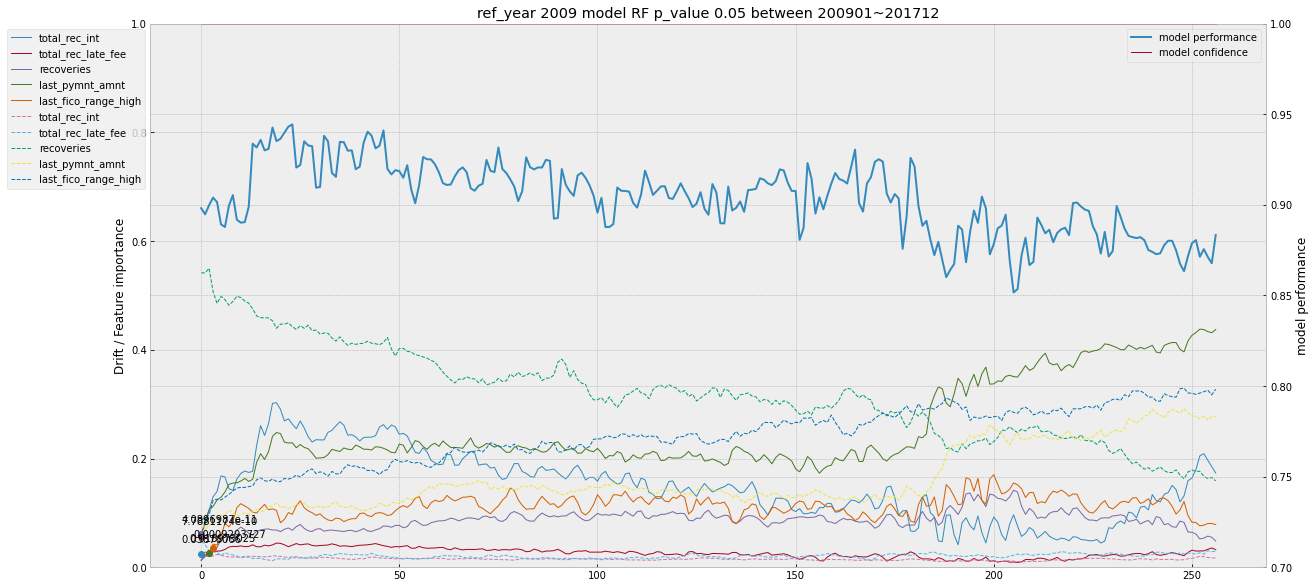

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'total_rec_int']
============================== Drift detect from year 2009 ==============================
 15000/1281415 step 4 day 201102 index 29061 model_ver 0 drift 5 acc 0.9040 cfd 1.0000
================================================== Train ==================================================
new reference data index 1109~29061, length 27953
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'term']

 35000/1281415 step 8 day 201201 index 49061 model_ver 1 drift 5 acc 0.9115 cfd 1.0000
================================================== Train ==================================================
new reference data index 1109~49061, length 47953
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'term']

 65000/1281415 step 14 day 201209 index 79061 model_ver 2 drift 5 acc 0.9452 cfd 1.0000


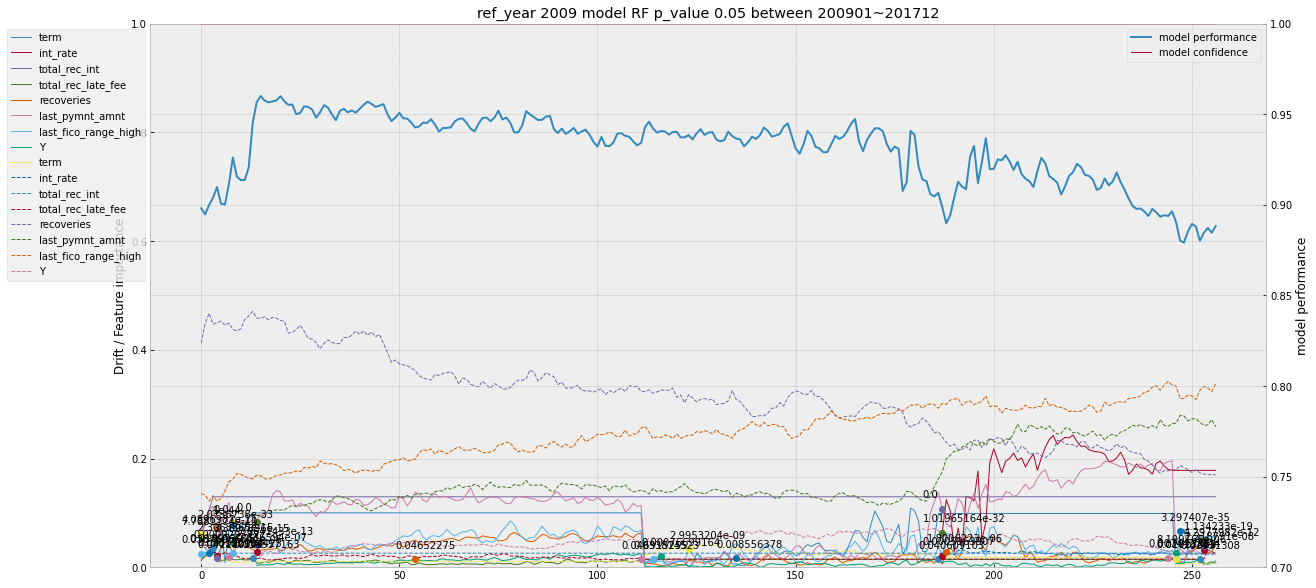

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'term']
============================== Drift detect from year 2010 ==============================
 1270000/1271697 step 255 day 201712 index 1285476 model_ver 0 drift 3 acc 0.8821 cfd 1.0000

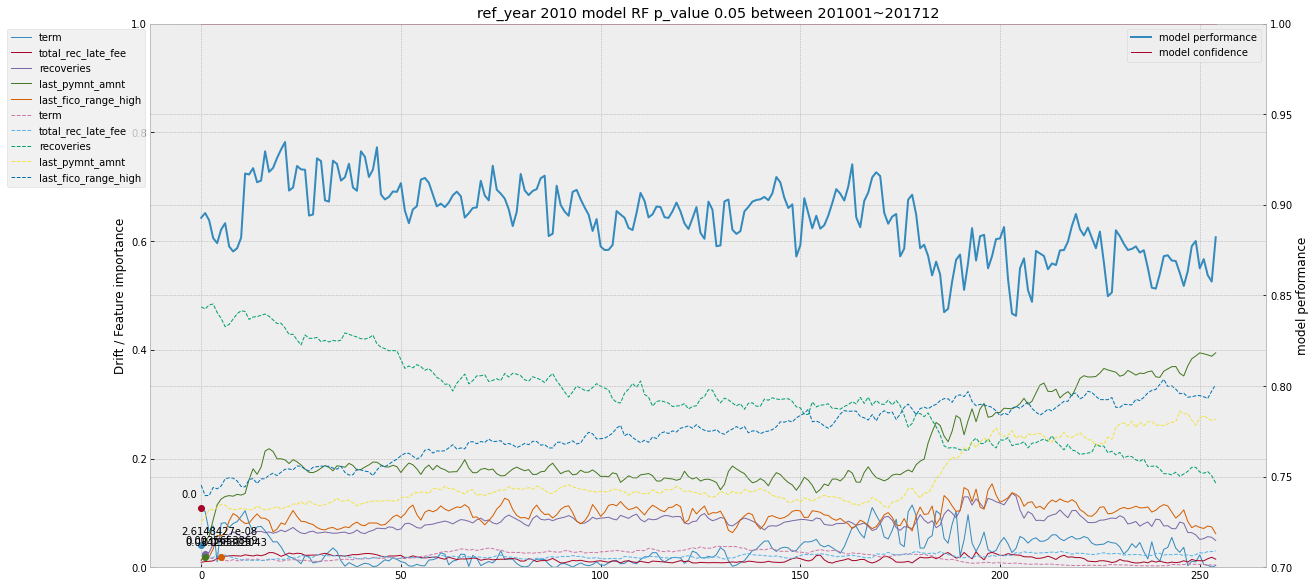

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'term']
============================== Drift detect from year 2010 ==============================
 25000/1271697 step 6 day 201112 index 48779 model_ver 0 drift 5 acc 0.8864 cfd 1.0000
================================================== Train ==================================================
new reference data index 5797~48779, length 42983
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'int_rate', 'total_rec_late_fee']

 85000/1271697 step 18 day 201301 index 108779 model_ver 1 drift 5 acc 0.9468 cfd 1.0000
================================================== Train ==================================================
new reference data index 5797~108779, length 102983
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 360000/1271697 step 73 day 201409 index 383779 model_ver 2 drift 5 acc 0.9270 cfd 1.0000
================

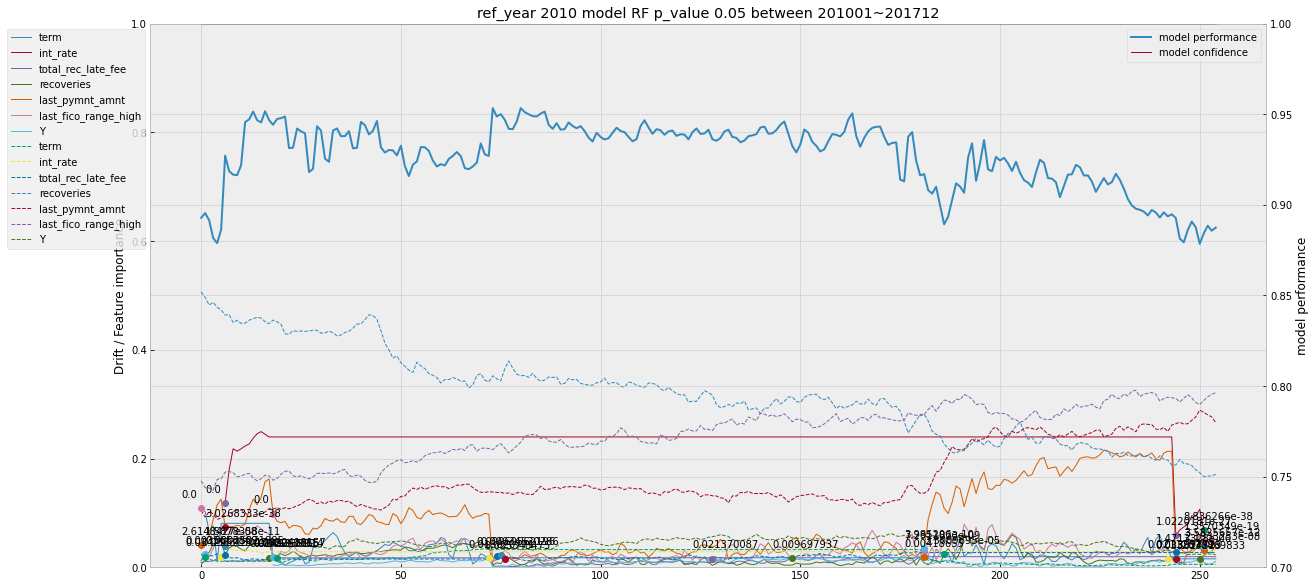

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'int_rate', 'total_rec_late_fee']
============================== Drift detect from year 2011 ==============================
 1250000/1253113 step 251 day 201712 index 1285476 model_ver 0 drift 4 acc 0.8792 cfd 1.0000

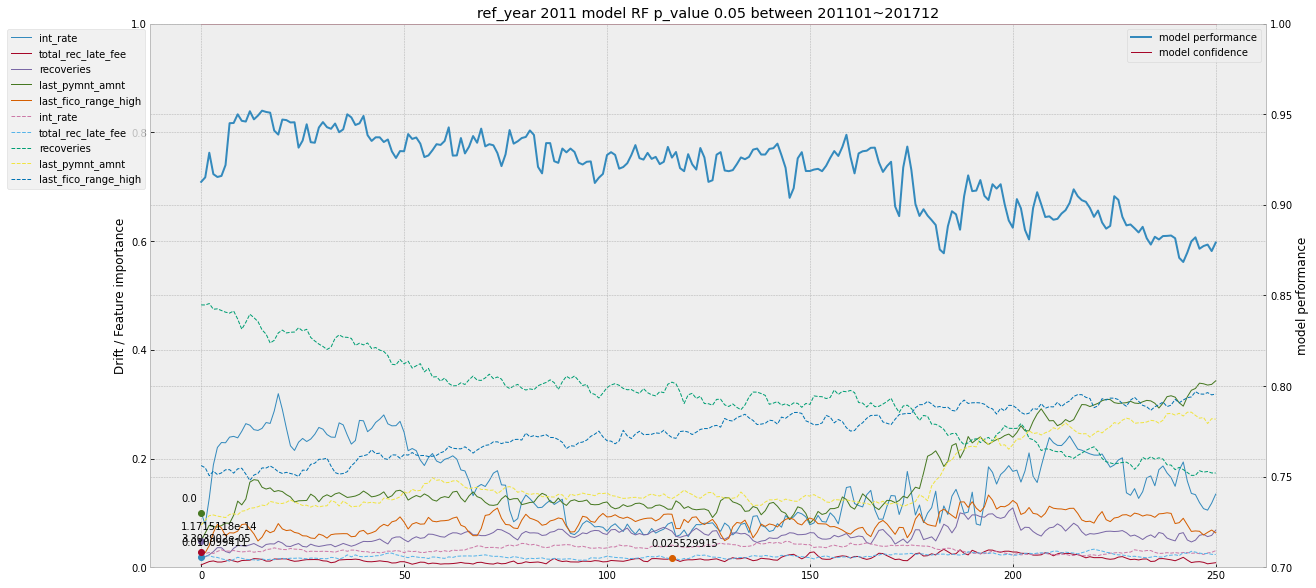

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'int_rate', 'total_rec_late_fee']
============================== Drift detect from year 2011 ==============================
 580000/1253113 step 117 day 201507 index 622363 model_ver 0 drift 5 acc 0.9261 cfd 1.0000
================================================== Train ==================================================
new reference data index 17294~622363, length 605070
monitoring_feature ['recoveries', 'last_pymnt_amnt', 'last_fico_range_high', 'Y', 'int_rate']

 915000/1253113 step 184 day 201604 index 957363 model_ver 1 drift 5 acc 0.8919 cfd 1.0000
================================================== Train ==================================================
new reference data index 17294~957363, length 940070
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'total_rec_late_fee']

 1240000/1253113 step 249 day 201711 index 1282363 model_ver 2 drift 5 acc 0.8866 cfd 1.0000
==

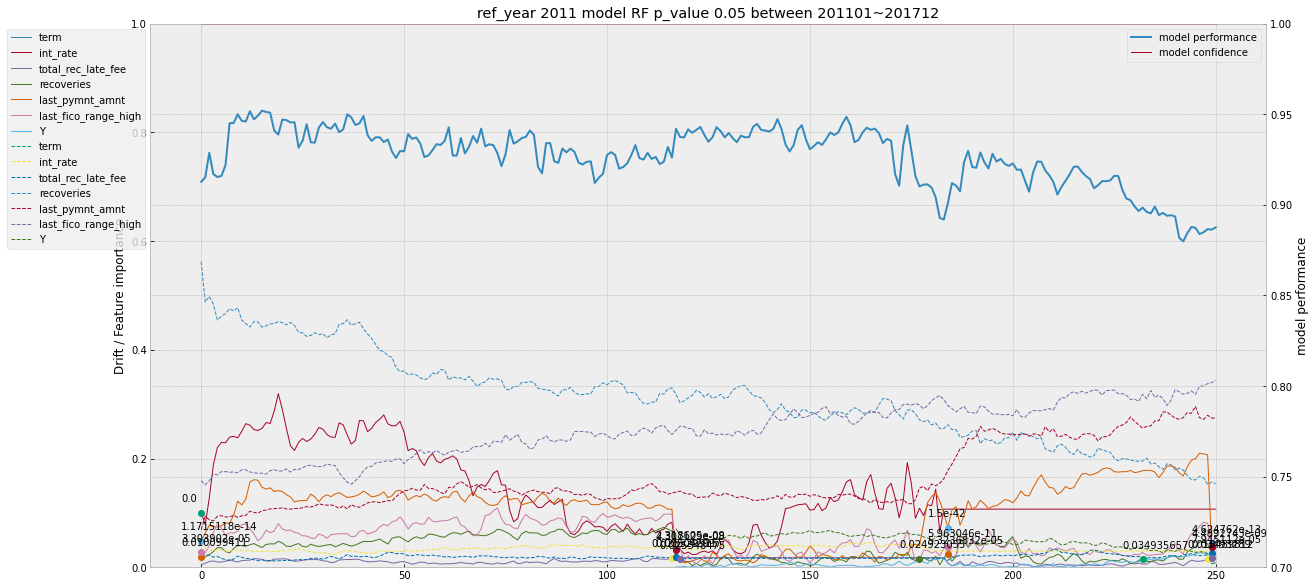

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']
============================== Drift detect from year 2012 ==============================
 1210000/1211924 step 243 day 201712 index 1285476 model_ver 0 drift 4 acc 0.8831 cfd 1.0000

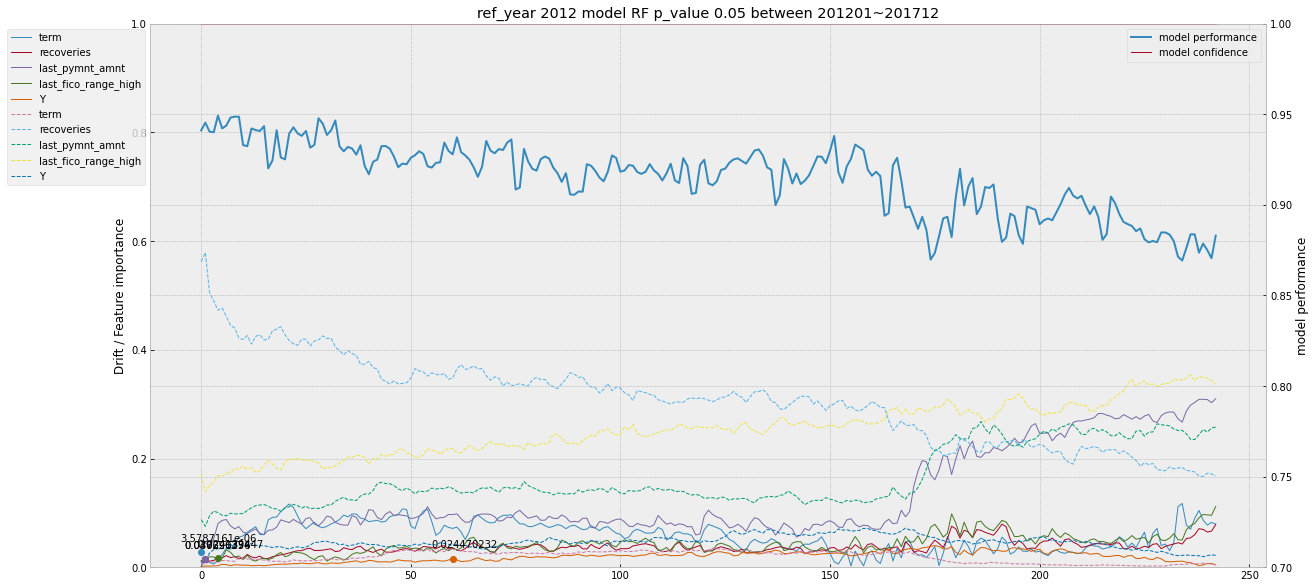

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']
============================== Drift detect from year 2012 ==============================
 300000/1211924 step 61 day 201409 index 383552 model_ver 0 drift 5 acc 0.9279 cfd 1.0000
================================================== Train ==================================================
new reference data index 38969~383552, length 344584
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 645000/1211924 step 130 day 201510 index 728552 model_ver 1 drift 5 acc 0.9433 cfd 1.0000
================================================== Train ==================================================
new reference data index 38969~728552, length 689584
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 870000/1211924 step 175 day 201604 index 953552 model_ver 2 drift 5 acc 0.8902 cfd 1.0000
============================================

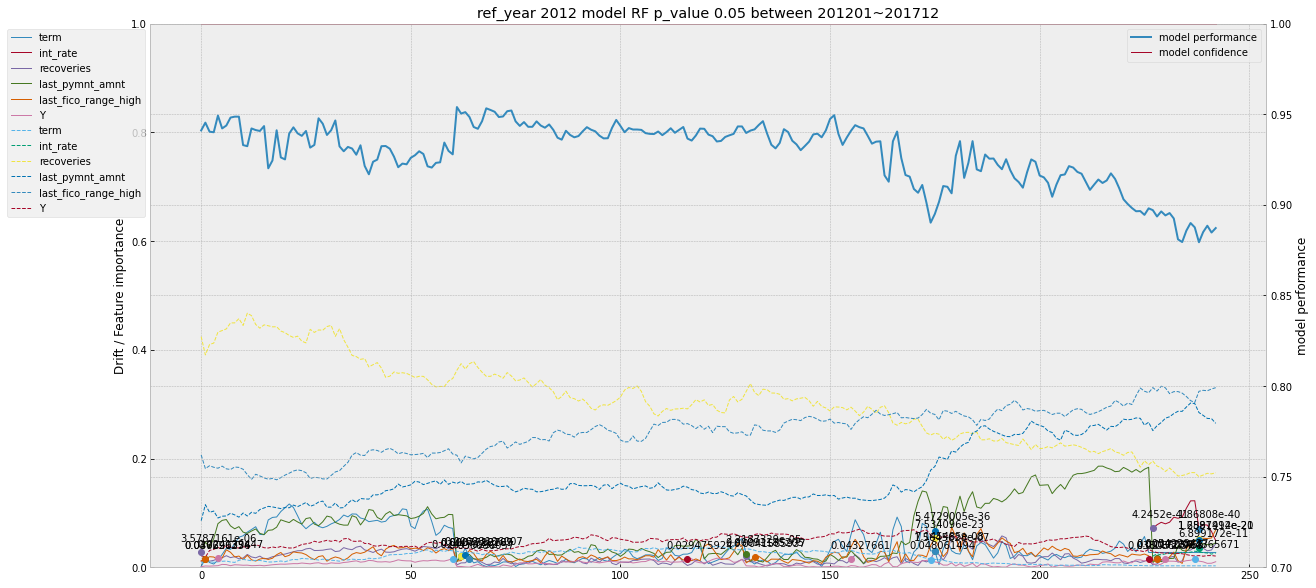

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']
============================== Drift detect from year 2013 ==============================
 1100000/1102423 step 221 day 201712 index 1285476 model_ver 0 drift 4 acc 0.8762 cfd 1.0000

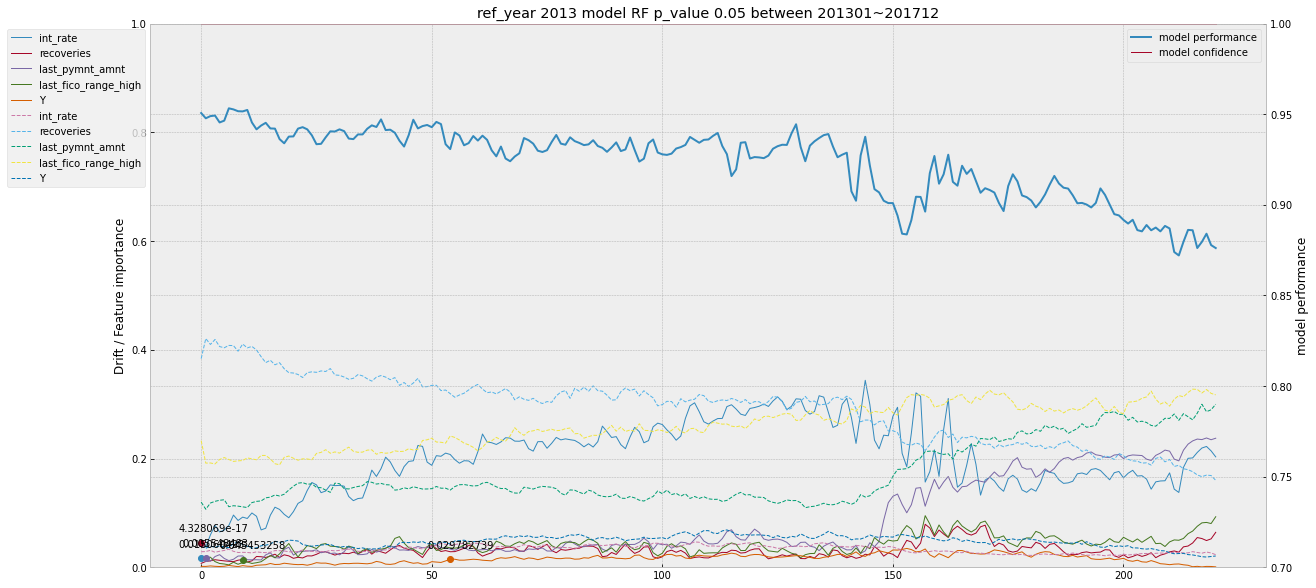

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']
============================== Drift detect from year 2013 ==============================
 270000/1102423 step 55 day 201501 index 463053 model_ver 0 drift 5 acc 0.9308 cfd 1.0000
================================================== Train ==================================================
new reference data index 92229~463053, length 370825
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']

 705000/1102423 step 142 day 201603 index 898053 model_ver 1 drift 5 acc 0.9164 cfd 1.0000
================================================== Train ==================================================
new reference data index 92229~898053, length 805825
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 765000/1102423 step 154 day 201604 index 958053 model_ver 2 drift 5 acc 0.8909 cfd 1.0000
====================================

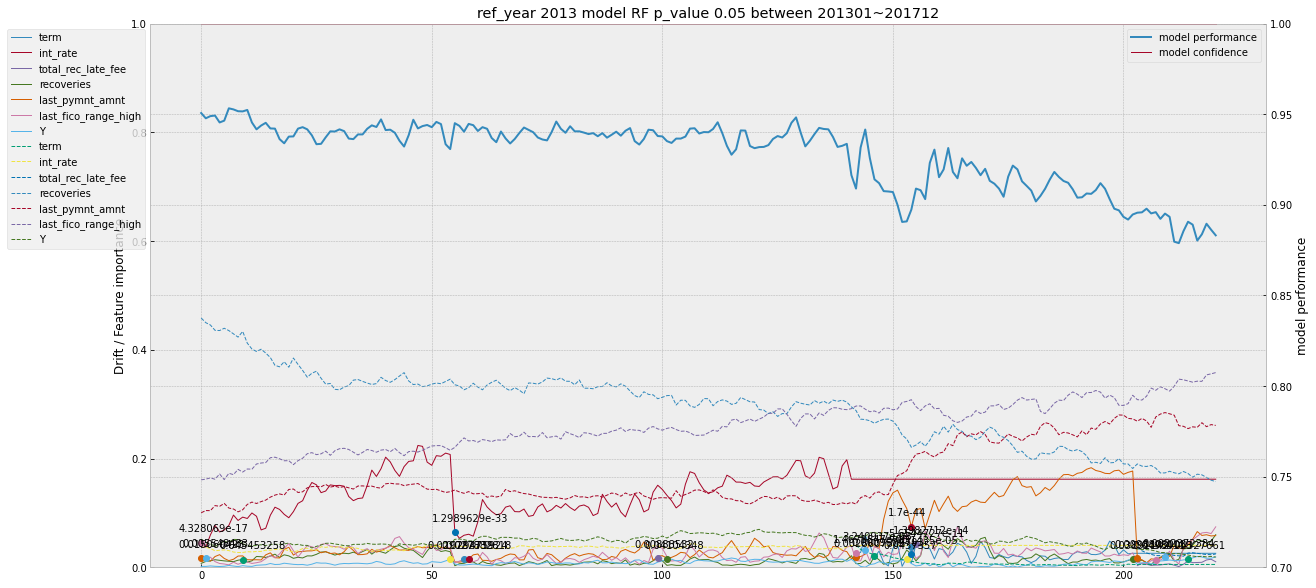

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']
============================== Drift detect from year 2014 ==============================
 900000/904102 step 181 day 201712 index 1285476 model_ver 0 drift 3 acc 0.8874 cfd 1.0000

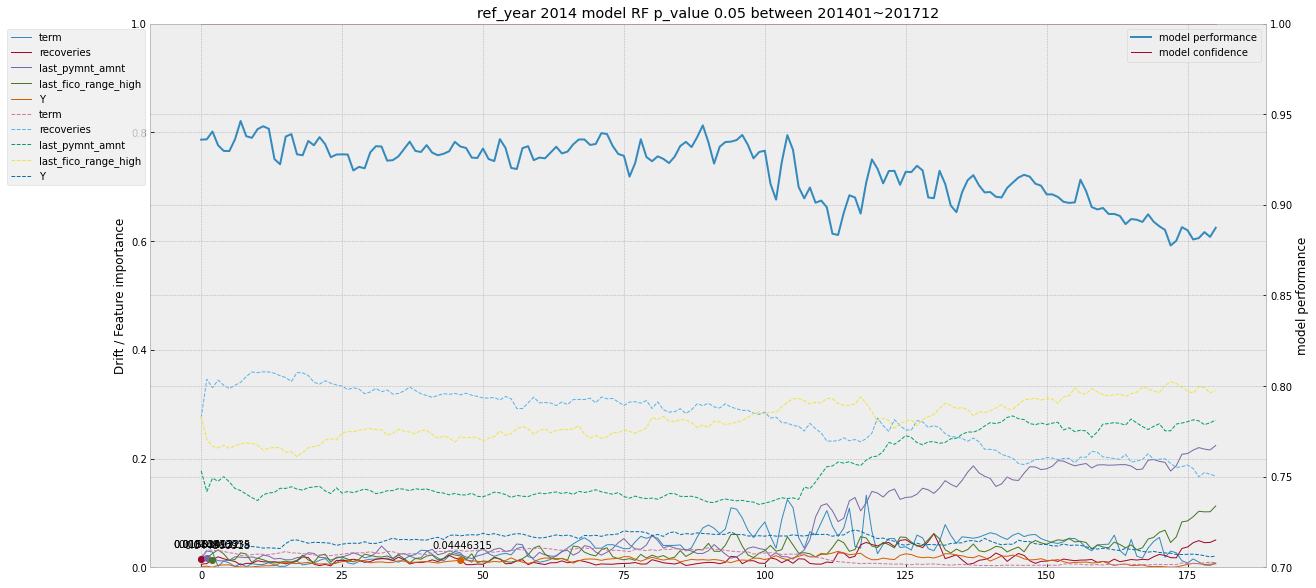

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']
============================== Drift detect from year 2014 ==============================
 230000/904102 step 47 day 201506 index 621374 model_ver 0 drift 5 acc 0.9322 cfd 1.0000
================================================== Train ==================================================
new reference data index 226855~621374, length 394520
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']

 565000/904102 step 114 day 201604 index 956374 model_ver 1 drift 5 acc 0.8917 cfd 1.0000
================================================== Train ==================================================
new reference data index 226855~956374, length 729520
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'term', 'Y']

 810000/904102 step 163 day 201705 index 1201374 model_ver 2 drift 5 acc 0.8959 cfd 1.0000
============================================

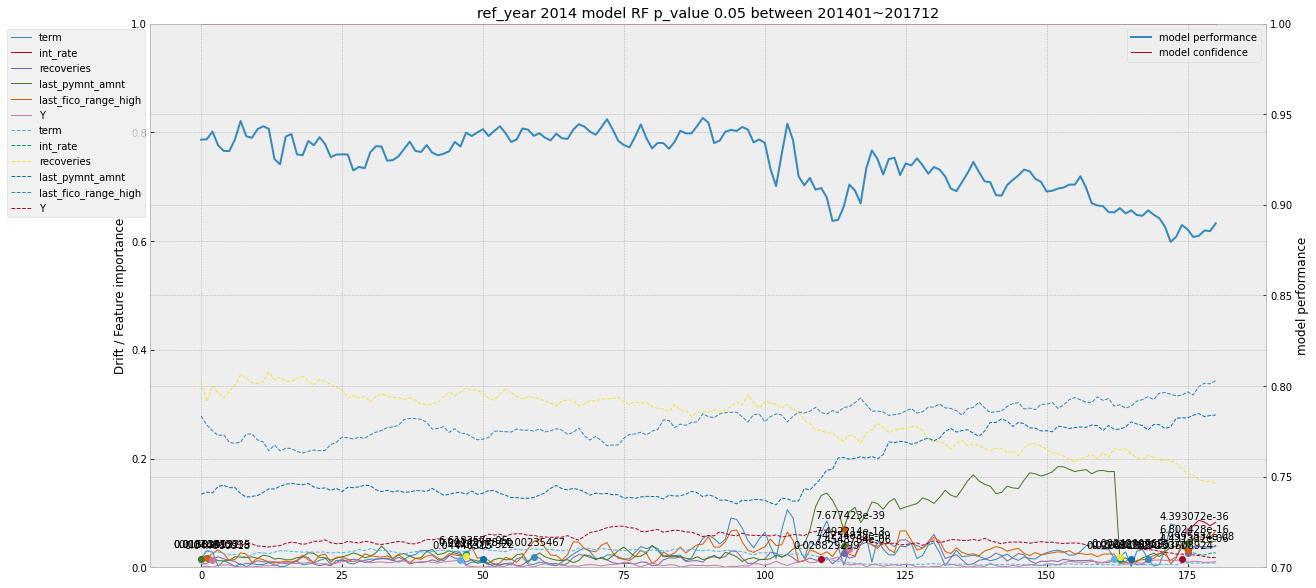

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']
============================== Drift detect from year 2015 ==============================
 575000/575468 step 116 day 201712 index 1285476 model_ver 0 drift 3 acc 0.8098 cfd 1.0000

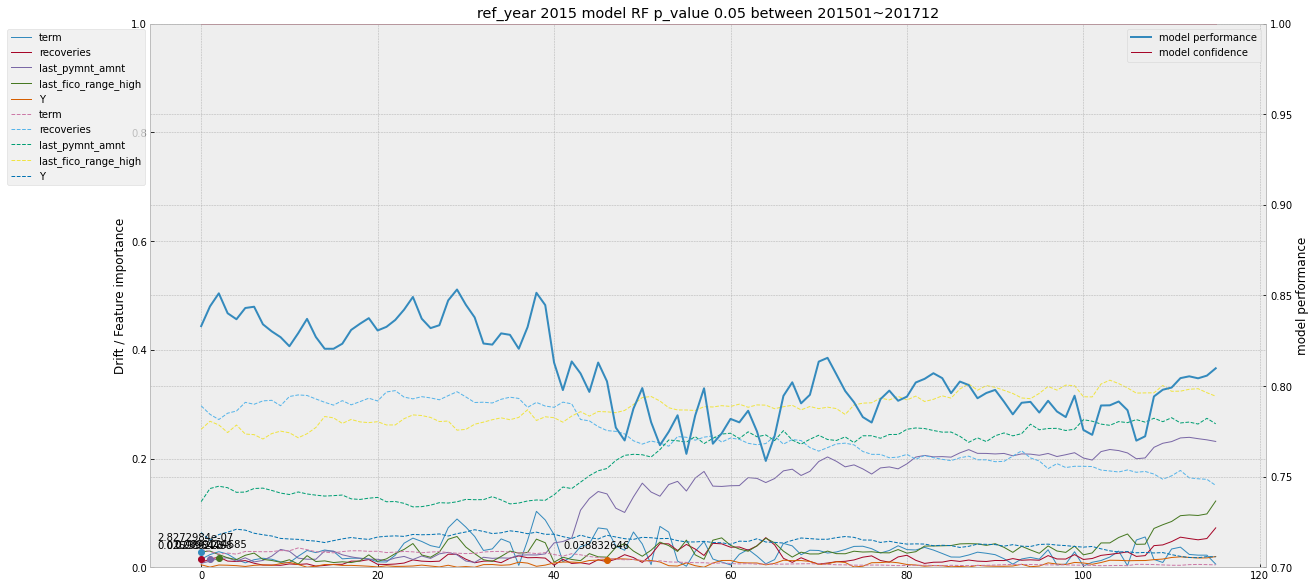

monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'term']
============================== Drift detect from year 2015 ==============================
 235000/575468 step 48 day 201604 index 955008 model_ver 0 drift 5 acc 0.7771 cfd 1.0000
================================================== Train ==================================================
new reference data index 449677~955008, length 505332
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']

 495000/575468 step 100 day 201706 index 1215008 model_ver 1 drift 5 acc 0.7964 cfd 1.0000
================================================== Train ==================================================
new reference data index 449677~1215008, length 765332
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']

 550000/575468 step 111 day 201710 index 1270008 model_ver 2 drift 5 acc 0.8861 cfd 1.0000
==================================

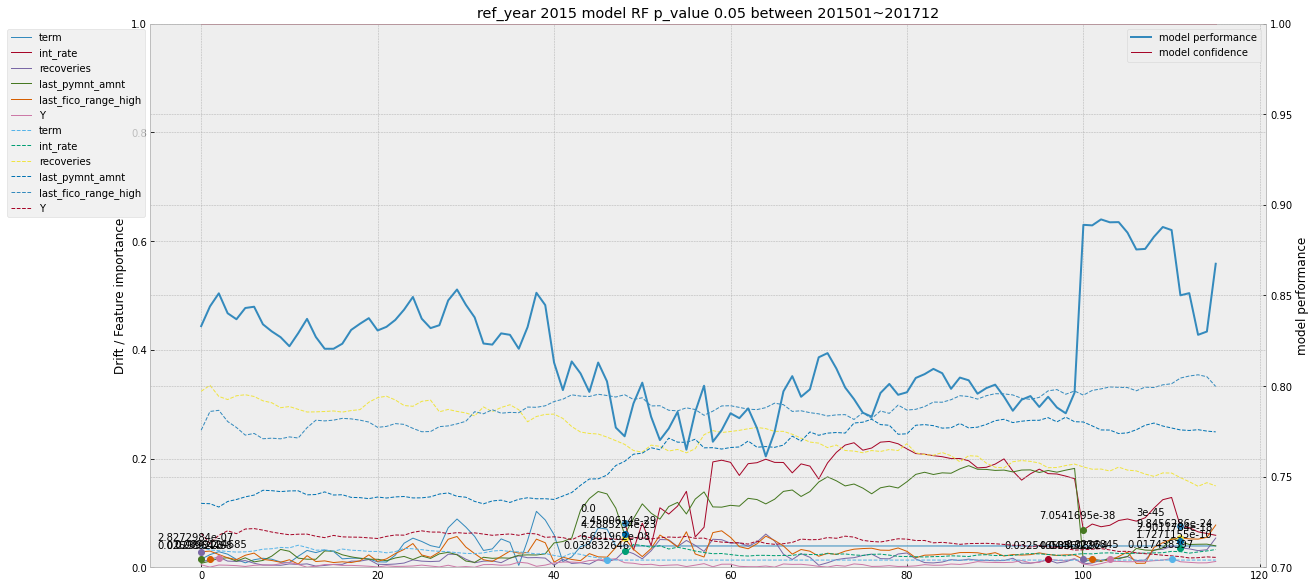

monitoring_feature ['last_fico_range_high', 'recoveries', 'last_pymnt_amnt', 'Y', 'int_rate']
============================== Drift detect from year 2016 ==============================
 225000/225511 step 46 day 201712 index 1285476 model_ver 0 drift 4 acc 0.8806 cfd 1.0000

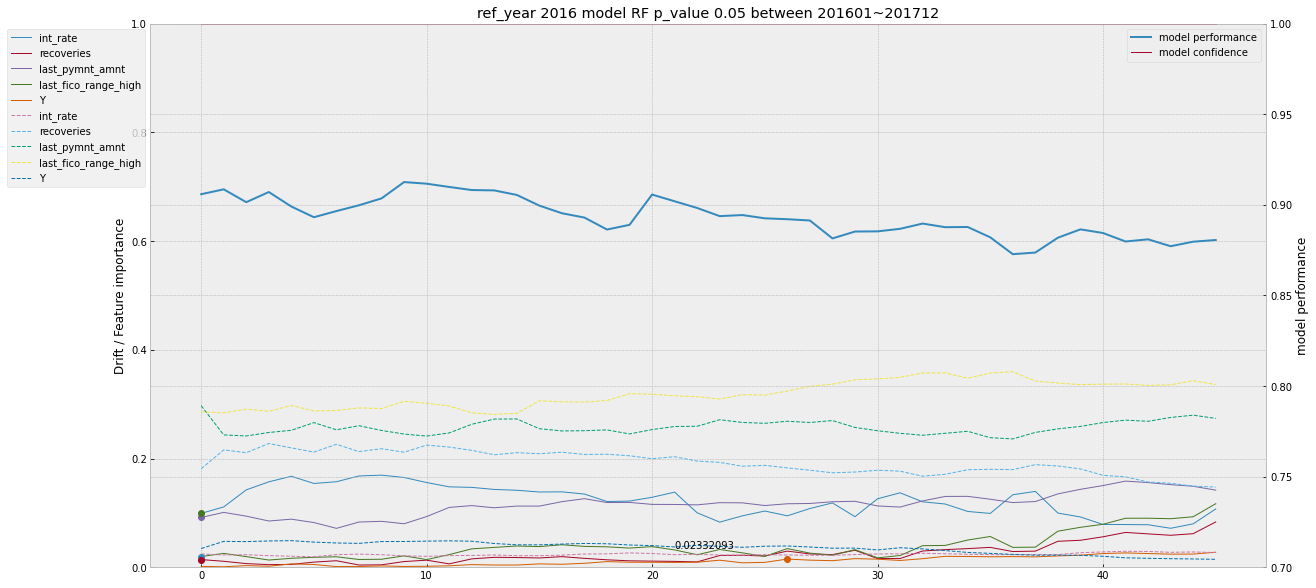

monitoring_feature ['last_fico_range_high', 'recoveries', 'last_pymnt_amnt', 'Y', 'int_rate']
============================== Drift detect from year 2016 ==============================
 130000/225511 step 27 day 201705 index 1199965 model_ver 0 drift 5 acc 0.8921 cfd 1.0000
================================================== Train ==================================================
new reference data index 824765~1199965, length 375201
monitoring_feature ['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'Y', 'int_rate']

 190000/225511 step 39 day 201709 index 1259965 model_ver 1 drift 5 acc 0.8086 cfd 1.0000
================================================== Train ==================================================
new reference data index 824765~1259965, length 435201
monitoring_feature ['last_fico_range_high', 'recoveries', 'last_pymnt_amnt', 'Y', 'total_rec_late_fee']

 225000/225511 step 46 day 201712 index 1285476 model_ver 2 drift 1 acc 0.8826 cfd 1.0000

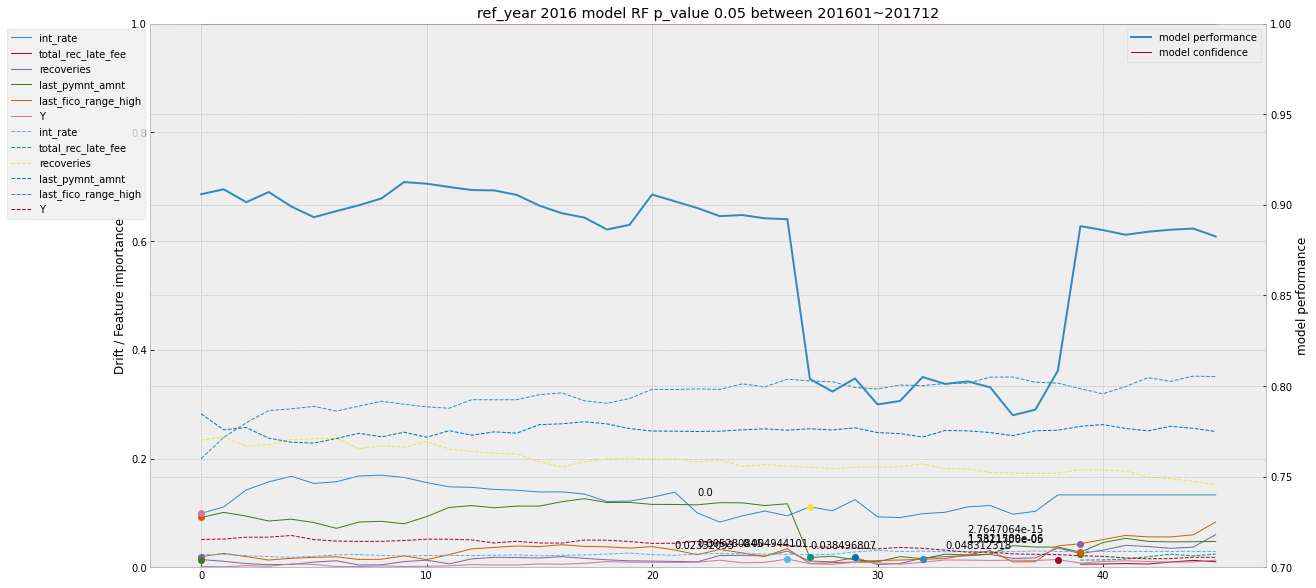

In [ ]:
for year in range(2009,2017):
    REFERENCE_YEAR = year

    scan_result = scan_data4(detect_p_val=0.05,is_do_retrain=False)
    plot_drift(scan_result,span = 1)
    scan_result = scan_data4(detect_p_val=0.05,is_do_retrain=True)
    plot_drift(scan_result,span = 1)